# New York City Taxi & Limousine Commission (NYC TLC)
> #### Understand and Predict Taxi Ridership Behavior

**Background:** 
Since 1971, NYC TLC has been regulating and overseeing the licensing of New York City's taxi cabs, for-hire vehicles, commuter vans, and paratransit vehicles.

### Table of Contents
 1. [Plan](#plan)
 2. [Analyze](#analyze)
    * [EDA](#eda)
    * [Visualizations](#viz)
    * [A/B test](#AB)
    * [Linear regression model](#regression)
        * [Outliers](#outliers)
        * [Imputations](#impute)
        * [Feature Engineering](#lm_engineering)
        * [More EDA](#lm_eda)
        * [Prepare for linear model](#lm_prep)
        * [Fit model](#lm_fit)
        * [Evaluate results](#lm_eval)
        * [Comments](#lm_notes)
    * [More feature engineering](#engineering)
    * [Prepare for modeling](#prep)
3. [Construct](#construct)
    * [Random forest model](#forest)
    * [XGBoost model](#boost)      
4. [Execute](#execute)    

<a id='plan'></a>
# **Plan** stage of **P**ACE workflow
***
> Scope of project is defined and informational needs of the organization are identified.

**Stakeholders:** NYC TLC

**Purpose:** To find ways to generate more revenue for taxi cab drivers.

**Goal:** Predict whether or not a customer is a generous tipper (ie, $\ge 20\%$).
- Initial goal: Predict if a customer will **not** leave a tip.
    - Ethical considerations: A false negative (FN) would inform the drivers that the customer will leave a tip when in fact they won't, thereby causing disappointment; this doesn't seem too harmful since this is normal when there isn't a model involved. A false positive (FP) would inform the cab drivers that a prospective customer will _not_ leave a tip eventhough they actually would. This may cause the drivers not to pick up the customer, thereby unfairly effecting this customer negatively and making it difficult for them to find a cab. This should be avoided. Furthermore, even correct predictions from the model would cause prejudice against customers who don't have the means to tip, effectively limiting equal access to taxis. This is ethically problematic. Can we therefore revise the goal?
- Revised goal: Predict if a customer will leave a **generous** tip.
    - Ethical considerations: This is better because it still allows cab drivers to increase their revenue by prioritizing generous tippers without limiting equal access to such an extent. A FN would tell the drivers that the customer will _not_ be generous when in fact they will, resulting in a pleasant suprise for the driver. A FP would inform the drivers that a prospective customer would leave a generous tip when in fact they won't, causing some normal disappointment. Although customers who don't have the means to tip would still face more difficultly getting a cab, they would not be targeted specifically anymore but would instead be part of the group of customers who do not tip generously. 

**What data do I have?**

The dataset is provided by the Google Advanced Data Analytics Professional Certificate, and is based on NYC OpenData found __[here](https://catalog.data.gov/dataset/2017-yellow-taxi-trip-data)__.

Column descriptions from the data dictionary:
***
- VendorID:
    - A code indicating the TPEP provider that provided the record.
        - 1=Creative Mobile Technologies, LLC
        - 2=VeriFone Inc.
- tpep_pickup_datetime:
    - The date and time when the meter was engaged.
- tpep_dropoff_datetime:
    - The date and time when the meter was disengaged.
- passenger_count:
    - The number of passengers in the vehicle.
- trip_distance:
    - The elapsed trip distance in miles reported by the taximeter.
- RatecodelD:
    - The final rate code in effect at the end of the trip.
        - 1= Standard rate
        - 2=JFK
        - 3=Newark
        - 4=Nassau or Westchester
        - 5=Negotiated fare
        - 6=Group ride
        - 99 = Null/unknown
        - 5=Negotiated fare
        - 6=Group ride
        - 99 = Null/unknown
- store_and_fwd_flag:
    - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server.
        - Y= store and forward trip
        - N= not a store and forward trip
- PULocationID:
    - TLC Taxi Zone in which the taximeter was engaged
- DOLocationID:
    - TLC Taxi Zone in which the taximeter was disengaged
- payment_type:
    - A numeric code signifying how the passenger paid for the trip.
        - 0= Flex Fare trip
        - 1= Credit card
        - 2= Cash
        - 3= No charge
        - 4= Dispute
        - 5= Unknown
        - 6= Voided trip
- fare_amount:
    - The time-and-distance fare calculated by the meter. For additional information on the following columns, see https://www.nyc.gov/site/tlc/passengers/taxi-fare.page
- extra:
    - Miscellaneous extras and surcharges.
- mta_tax:
    - Tax that is automatically triggered based on the metered rate in use.
- tip_amount:
    - Tip amount – This field is automatically populated for credit card tips. Cash tips are not included.
- tolls_amount:
    - Total amount of all tolls paid in trip.
- improvement_surcharge:
    - Improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015.
- total_amount:
    - The total amount charged to passengers. Does not include cash tips.
- congestion_surcharge:
    - Total amount collected in trip for NYS congestion surcharge.
- airport_fee:
    - For pick up only at LaGuardia and John F. Kennedy Airports.
***

### Import packages

In [1]:
# Packages for numerics + dataframes
import numpy as np
import pandas as pd
from scipy import stats

# Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Packages for data prep
from sklearn.preprocessing import StandardScaler

# Packages for OLS
from sklearn.linear_model import LinearRegression

# Packages for splitting data and hyperparameter tuning
from sklearn.model_selection import train_test_split, GridSearchCV

# Packages for ensemble learning
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Packages for performance metrics
from sklearn import metrics

# Function to help plot feature importance 
from xgboost import plot_importance

# from sklearn.metrics import roc_auc_score, roc_curve
# from sklearn.metrics import accuracy_score, precision_score, recall_score,\
# f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay,\
# mean_absolute_error, r2_score, mean_squared_error

# To save any models to file
import pickle

# This shows all columns, preventing Juptyer from redacting them.
pd.set_option('display.max_columns', None)

# Set Matplotlib defaults
# plt.style.use('seaborn-v0_8-whitegrid')

print('Setup complete!')

Setup complete!


In [2]:
print('Using versions:')
print('numpy', np.__version__)
print('pandas', pd.__version__)
print('seaborn', sns.__version__)

Using versions:
numpy 1.26.4
pandas 2.2.1
seaborn 0.12.2


In [3]:
# Run the machine learning algorithms or load the pre-trained models?
# (Toggle this as desired.)
# Note: Running on an Apple M1 chip, the random forest model required about 1.5 minutes to train,
# whereas the XGBoost model required over 10 minutes.
load_models = True

In [4]:
# plt.style.available

<a id='analyze'></a>
# **Analyze** stage of P**A**CE workflow
***
> Necessary data is acquired from primary and secondary sources and then cleaned, reorganized, and analyzed.

## Load the data and perform EDA <a id='eda'></a>

Exploratory data analysis (EDA) helps a data professional to get to know the data, understand its outliers, clean its missing values, and prepare it for future modeling.

In [5]:
df = pd.read_csv('data/2017_Yellow_Taxi_Trip_Data.csv')
df.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,24870114,2,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56
1,35634249,1,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80
2,106203690,1,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75
3,38942136,2,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69
4,30841670,2,04/15/2017 11:32:20 PM,04/15/2017 11:49:03 PM,1,4.37,1,N,4,112,2,16.5,0.5,0.5,0.00,0.0,0.3,17.80


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22699 entries, 0 to 22698
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             22699 non-null  int64  
 1   VendorID               22699 non-null  int64  
 2   tpep_pickup_datetime   22699 non-null  object 
 3   tpep_dropoff_datetime  22699 non-null  object 
 4   passenger_count        22699 non-null  int64  
 5   trip_distance          22699 non-null  float64
 6   RatecodeID             22699 non-null  int64  
 7   store_and_fwd_flag     22699 non-null  object 
 8   PULocationID           22699 non-null  int64  
 9   DOLocationID           22699 non-null  int64  
 10  payment_type           22699 non-null  int64  
 11  fare_amount            22699 non-null  float64
 12  extra                  22699 non-null  float64
 13  mta_tax                22699 non-null  float64
 14  tip_amount             22699 non-null  float64
 15  to

We can see from .info() that there are 22,699 rows (ie, taxi rides), no missing values, and all variables are numeric except for three that are of type string, namely the two datetime variables and the store_and_fwd_flag variable. The datetime variables are useful and will need to be converted to datetime objects.

In [7]:
# Convert date columns to datetime
df['tpep_pickup_datetime']=pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime']=pd.to_datetime(df['tpep_dropoff_datetime'])

We will ignore the other object variable, store_and_fwd_flag, because it does not seem useful for our analysis.

In [8]:
df.describe()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
count,2.269900e+04,22699.000000,22699,22699,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000
mean,5.675849e+07,1.556236,2017-06-29 07:32:48.973126656,2017-06-29 07:49:49.799726848,1.642319,2.913313,1.043394,162.412353,161.527997,1.336887,13.026629,0.333275,0.497445,1.835781,0.312542,0.299551,16.310502
min,1.212700e+04,1.000000,2017-01-01 00:08:25,2017-01-01 00:17:20,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,-120.000000,-1.000000,-0.500000,0.000000,0.000000,-0.300000,-120.300000
25%,2.852056e+07,1.000000,2017-03-30 03:09:38.500000,2017-03-30 03:11:20.500000,1.000000,0.990000,1.000000,114.000000,112.000000,1.000000,6.500000,0.000000,0.500000,0.000000,0.000000,0.300000,8.750000
50%,5.673150e+07,2.000000,2017-06-23 12:35:57,2017-06-23 12:55:11,1.000000,1.610000,1.000000,162.000000,162.000000,1.000000,9.500000,0.000000,0.500000,1.350000,0.000000,0.300000,11.800000
75%,8.537452e+07,2.000000,2017-10-02 10:34:34,2017-10-02 10:53:47,2.000000,3.060000,1.000000,233.000000,233.000000,2.000000,14.500000,0.500000,0.500000,2.450000,0.000000,0.300000,17.800000
max,1.134863e+08,2.000000,2017-12-31 23:45:30,2017-12-31 23:49:24,6.000000,33.960000,99.000000,265.000000,265.000000,4.000000,999.990000,4.500000,0.500000,200.000000,19.100000,0.300000,1200.290000
std,3.274493e+07,0.496838,NaN,NaN,1.285231,3.653171,0.708391,66.633373,70.139691,0.496211,13.243791,0.463097,0.039465,2.800626,1.399212,0.015673,16.097295


Looking at .describe(), a few things stand out:
- There is an Unnamed column which is probably the index of the original (full) dataset that contained 113 million rows (as stated on the [NYC OpenData website](https://data.cityofnewyork.us/Transportation/2017-Yellow-Taxi-Trip-Data/biws-g3hs/about_data); this makes sense because the max value is in the 113M range. This much smaller dataset must have been sampled from the original.
- The minumum passenger count of 0 must be an error; this is likely because passenger_count values were entered by the taxi driver.
- The minimum trip distance is 0, which could mean that the taxi was hailed but the customer never took the ride.
- The min,max fair amounts are -120, 999.99 which must be erroneous, at least the minimum is for sure.

Let's investigate the trip distance variable first.

In [9]:
# Sort the data by trip distance from maximum to minimum value
df.sort_values(by='trip_distance', ascending=False)[['trip_distance', 'fare_amount']]

,trip_distance,fare_amount
9280,33.96,150.00
13861,33.92,200.01
6064,32.72,107.00
10291,31.95,131.00
29,30.83,80.00
...,...,...
2440,0.00,5.50
15916,0.00,8.50
1350,0.00,2.50
246,0.00,2.50


The rows with trip_distance = 0 yet non-zero fare_amounts are suspect.

In [10]:
# Sort the data by total amount and print the top 20 values
df_sorted = df.sort_values(by='total_amount', ascending=False)[['total_amount', 'trip_distance']]
df_sorted.head(20)

,total_amount,trip_distance
8476,1200.29,2.60
20312,450.30,0.00
13861,258.21,33.92
12511,233.74,0.00
15474,211.80,0.00
6064,179.06,32.72
16379,157.06,25.50
3582,152.30,7.30
11269,151.82,0.00
9280,150.30,33.96


There are some unusual values here when looking at the largest total amounts charged to passengers:
- The most expensive trip of ~$1,200 is for a short trip_distance of under 3 miles.
- In multiple cases, the total_amount is large for trips of 0 or ~ 0 miles.
- Some trips are around the same price (eg, for index=16379,3582) despite the trip_distance being different by a factor of almost 4.

In general, trip_distance does _not_ seem to correlate well with total_amount at these high values of total_amount.

In [11]:
# Print the bottom 20 values
df_sorted.tail(20)

,total_amount,trip_distance
14283,0.31,0.00
19067,0.30,0.10
10506,0.00,0.00
5722,0.00,0.00
4402,0.00,7.06
22566,0.00,0.00
1646,-3.30,0.04
18565,-3.80,0.10
314,-3.80,0.12
5758,-3.80,0.02


These negative values for total_amount are concerning, as is the observation of $0 for a trip distance of ~7 miles.

In [12]:
# How many of each payment type are represented in the data?
df['payment_type'].value_counts(normalize=True)

payment_type
1    0.672497
2    0.320146
3    0.005331
4    0.002027
Name: proportion, dtype: float64

According to the data dictionary, the payment method was encoded as follows:
1 = Credit card
2 = Cash
3 = No charge
4 = Dispute
5 = Unknown
6 = Voided trip

In our dataset, about 67% are credit card payments, 32% are cash payments, and the other categories each account for either less than 1% of the data (No charge, Dispute) or they are not present at all (Unknown, Voided trip). 

In [13]:
# What is the average tip for trips paid for with credit card, with cash, etc?
df[['payment_type', 'tip_amount']].groupby('payment_type').mean()

,tip_amount
payment_type,
1,2.7298
2,0.0000
3,0.0000
4,0.0000


As the data dictionary says, cash tips are not recorded. Hence, we have tip data only for credit card payments.

In [14]:
# How many times is each vendor ID represented in the data?
df['VendorID'].value_counts(normalize=True)

VendorID
2    0.556236
1    0.443764
Name: proportion, dtype: float64

About 56% are vendor 2 (VeriFone), and 44% are vendor 1 (Creative Mobile Technologies).

In [15]:
# What is the mean total amount for each vendor?
df[['VendorID', 'total_amount']].groupby('VendorID').mean()

,total_amount
VendorID,
1,16.298119
2,16.320382


The average total_amount is about the same for each vendor, slightly higher for vendor 2.

In [16]:
# Filter the data for credit card payments only
df_cc = df[df['payment_type'] == 1]

# Calculate the average tip amount for each passenger count (credit card payments only)
df_cc[['passenger_count', 'tip_amount']].groupby('passenger_count').agg(['mean', 'count'])

tip_amount       
                      mean  count
passenger_count                  
0                 2.610370     27
1                 2.714681  10977
2                 2.829949   2168
3                 2.726800    600
4                 2.607753    267
5                 2.762645    775
6                 2.643326    451

In [17]:
round(100*(2.829949 - 2.607753) / 2.607753, 2)

8.52

There is up to a 8.5% difference in average tip amount depending on the number of passengers, with 2 tipping the most, and 4 tipping the least. However, this fluctuation may be due to sample size issues because trips with 4 passengers are least represented in the dataset (other than the erroneous 0 passengers).

We also see that most taxi rides involve a single passenger. It is concerning that there are nearly 30 rides with 0 passengers.

## Visualizations <a id='viz'></a>
- Box plots will help view the quartiles of the data and determine outliers. 
- Scatter plots will help to visualize trends and patterns.
- Bar charts can be used to depict averages across categories.
- Histograms help visualize the distributions of values.

/Users/joseph/miniconda3/envs/portfolio_taxi/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


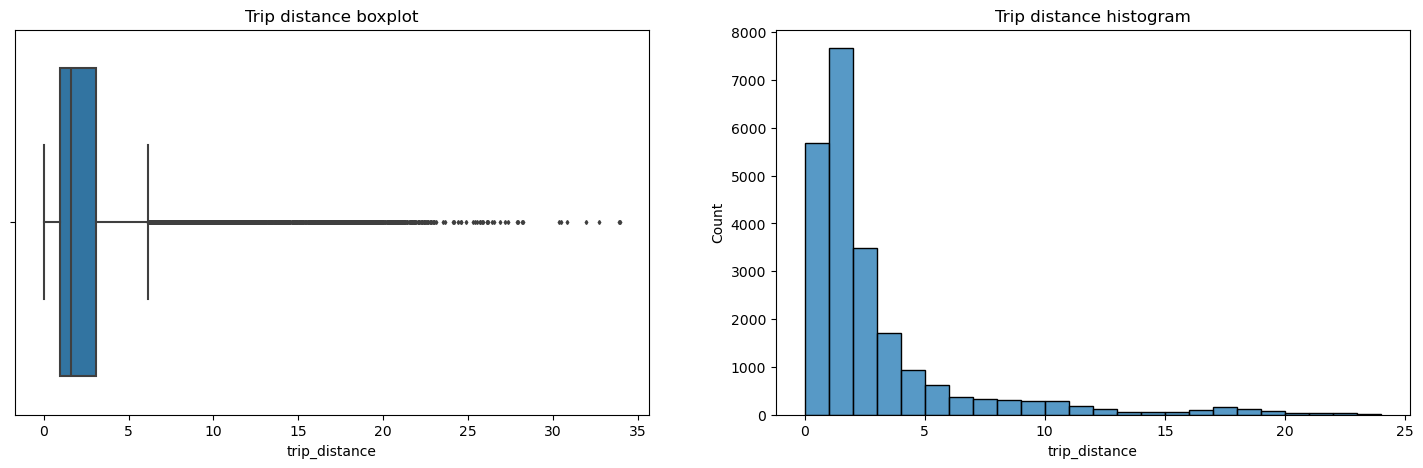

In [18]:
# Box plot and histogram of trip distance

fig, ax = plt.subplots(1, 2, figsize = (18,5))

sns.boxplot(x=df['trip_distance'], fliersize=2, ax=ax[0])
ax[0].set_title('Trip distance boxplot')

sns.histplot(df['trip_distance'], bins=range(0,25,1))
ax[1].set_title('Trip distance histogram')

plt.show()

The boxplot shows many outliers on the high end, namely where the trip distance is large.

The histogram shows that the majority of trips were under 2 miles, a distance beyond which there are increasingly fewer trips.

/Users/joseph/miniconda3/envs/portfolio_taxi/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


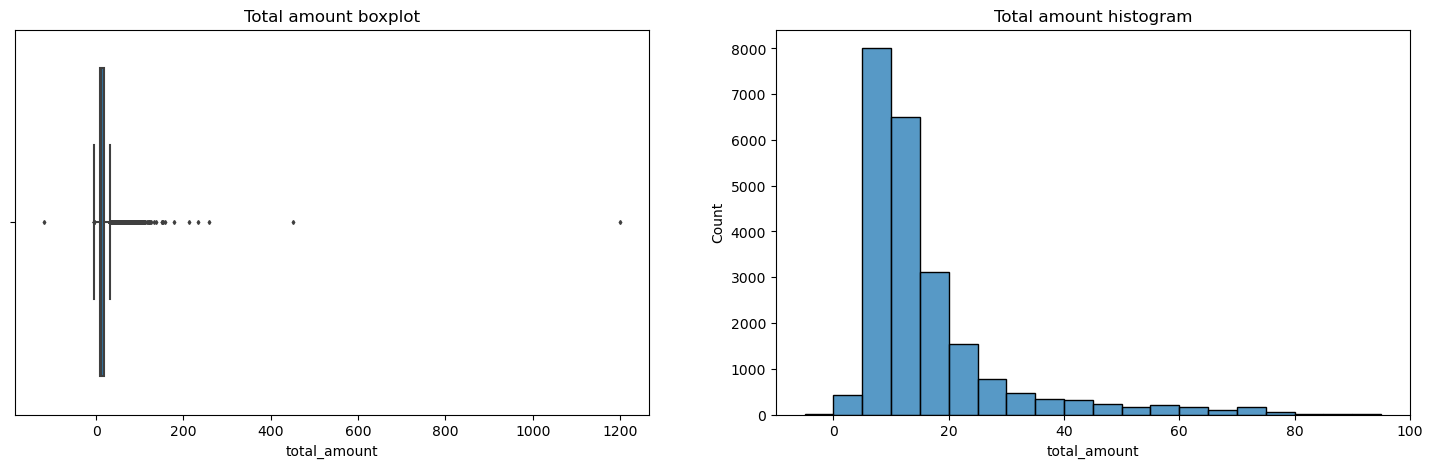

In [19]:
# Box plot and histogram of total amount

fig, ax = plt.subplots(1, 2, figsize = (18,5))

sns.boxplot(x=df['total_amount'], fliersize=2, ax=ax[0])
ax[0].set_title('Total amount boxplot')

sns.histplot(df['total_amount'], bins=range(-5,100,5))
ax[1].set_title('Total amount histogram')

plt.show()

The boxplot show some extreme outliers, both low and high.

The histogram is right skewed with the cost of most trips being in the $5-15 range.

/Users/joseph/miniconda3/envs/portfolio_taxi/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


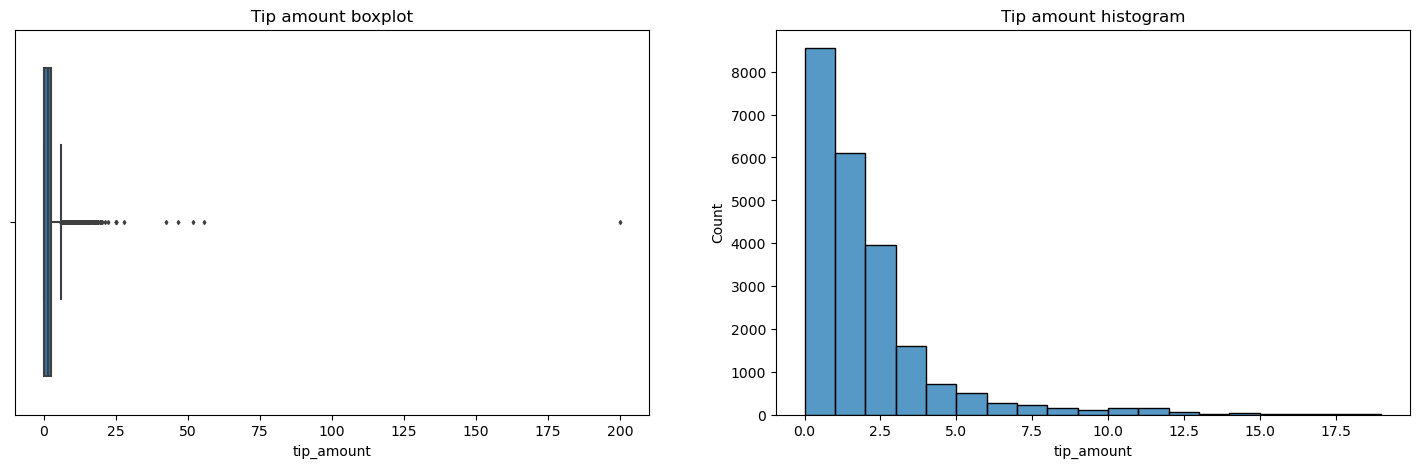

In [20]:
# Box plot and histogram of tip amount

fig, ax = plt.subplots(1, 2, figsize = (18,5))

sns.boxplot(x=df['tip_amount'], fliersize=2, ax=ax[0])
ax[0].set_title('Tip amount boxplot')

sns.histplot(df['tip_amount'], bins=range(0,20,1))
ax[1].set_title('Tip amount histogram')

plt.show()

The boxplot shows some extreme outliers exceeding $25.

The histogram is right skewed and shows that most tips are in the $0-3 range.

**Tip amount by vendor**

/Users/joseph/miniconda3/envs/portfolio_taxi/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/joseph/miniconda3/envs/portfolio_taxi/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/joseph/miniconda3/envs/portfolio_taxi/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/joseph/m

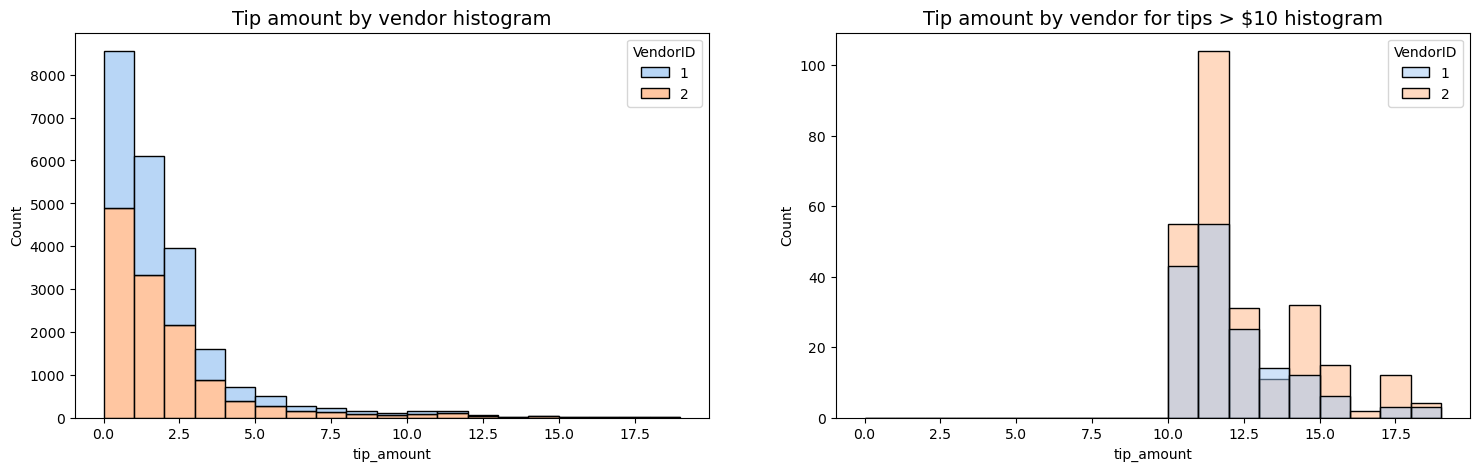

In [21]:
# Create histograms of tip_amount by vendor and for tips > $10
df_tips_over_ten = df[df['tip_amount'] > 10]

fig, ax = plt.subplots(1, 2, figsize = (18,5))

sns.histplot(data=df, x='tip_amount',
             bins=range(0,20,1),
             hue='VendorID',
             multiple='stack',
             palette='pastel',
             ax=ax[0])
ax[0].set_title('Tip amount by vendor histogram', fontsize=14)

sns.histplot(data=df[df['tip_amount'] > 10], x='tip_amount',
             bins=range(0,20,1),
             hue='VendorID',
             multiple='layer',
             palette='pastel',
             ax=ax[1])
ax[1].set_title('Tip amount by vendor for tips > $10 histogram', fontsize=14)

plt.show()

The first histogram shows a similar distribution between the two vendors. As we saw earlier, vendor 2 has a slightly higher share of the rides, namely 56%, and this proportion appears maintained across the tip amounts.

By zooming in on tips > $10 to see if either vendor gets a larger share of the more generous tips, there is no clear difference is distribution between the two vendors especially because differences may be due to low sample size at these high tip amounts.

**Average tips by passenger count**

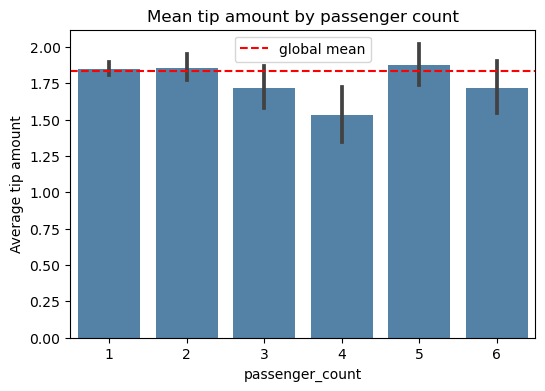

In [22]:
# Create bar plot for mean tips by passenger count (ignoring passenger_count of zero)

plt.figure(figsize=(6,4))
ax = sns.barplot(data=df[df['passenger_count'] > 0], 
            x='passenger_count', 
            y='tip_amount', 
            estimator='mean',
            color='steelblue'
                )
plt.ylabel('Average tip amount')
plt.title('Mean tip amount by passenger count')
ax.axhline(df['tip_amount'].mean(), ls='--', color='red', label='global mean')
ax.legend()
plt.show()

The mean tip amount varies minimally by passenger count, although it does drop noticably for four-passenger rides. The 95% confidence interval for these four-passenger rides does _not_ include the global mean, so this difference may be meaningful.

**Create month and day columns**

In [23]:
df['month'] = df['tpep_pickup_datetime'].dt.strftime('%b').str.lower()
df['day'] = df['tpep_pickup_datetime'].dt.day_name().str.lower()

**Plot total ride count and total revenue by month**

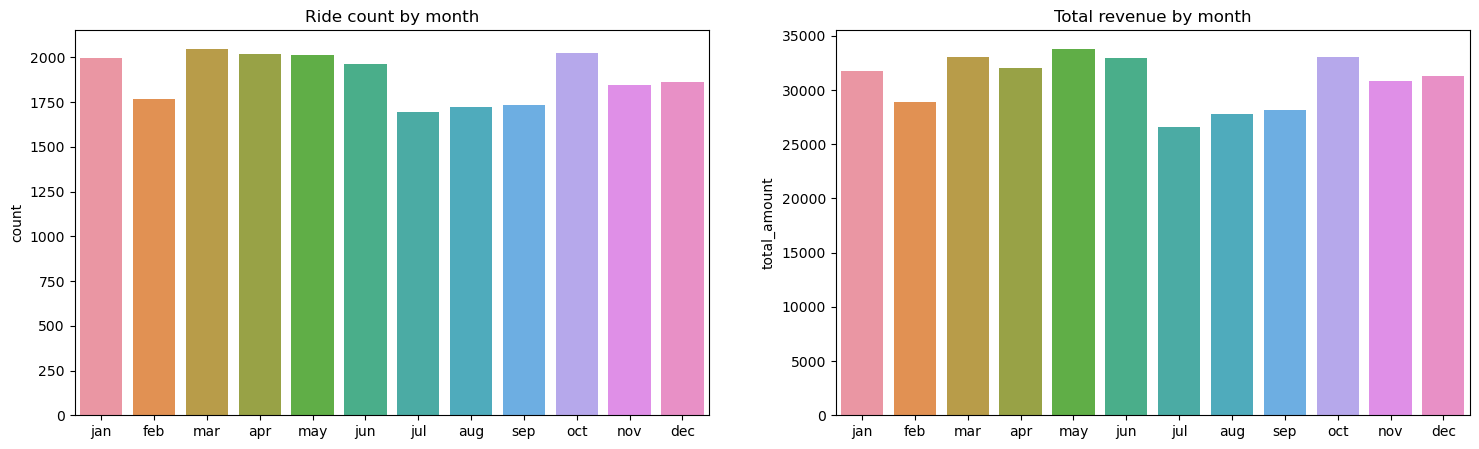

In [24]:
month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul',
               'aug', 'sep', 'oct', 'nov', 'dec']

fig, ax = plt.subplots(1,2, figsize = (18,5))

sns.countplot(df, x='month', order=month_order, ax=ax[0])
ax[0].set_xlabel('')
ax[0].set_title('Ride count by month')

sns.barplot(data=df, 
                x='month', 
                y='total_amount', 
                estimator='sum',
                order=month_order,
                errorbar=None,
                ax=ax[1]
                )
ax[1].set_xlabel('')
ax[1].set_title('Total revenue by month')

plt.show()

Monthly rides are fairly consistent but dip in February and the summer months of July, August, September.

Monthly revenue generally follows the pattern of monthly rides.

**Plot total ride count and total revenue by day of the week**

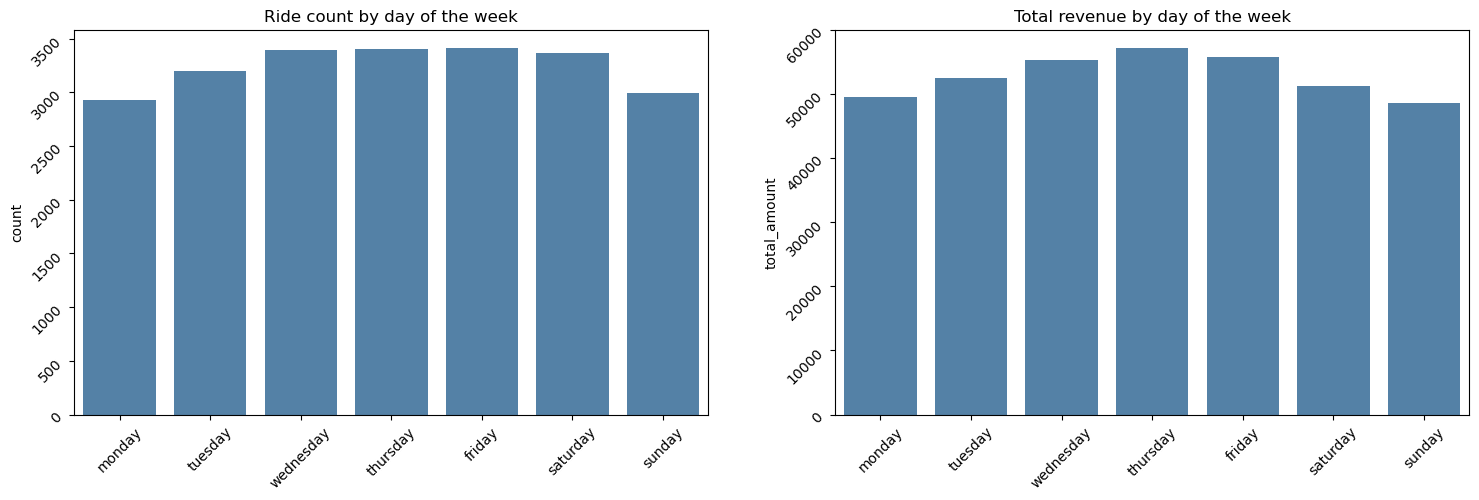

In [25]:
day_order = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']

fig, ax = plt.subplots(1, 2, figsize = (18,5))

sns.countplot(df, x='day', order=day_order, color='steelblue', ax=ax[0])
ax[0].tick_params(labelrotation=45)
ax[0].set_xlabel('')
ax[0].set_title('Ride count by day of the week')

sns.barplot(data=df, 
                x='day', 
                y='total_amount', 
                estimator='sum',
                order=day_order,
                color='steelblue',
                errorbar=None,
                ax=ax[1]
                )
ax[1].tick_params(labelrotation=45)
ax[1].set_xlabel('')
ax[1].set_title('Total revenue by day of the week')

plt.show()

Sunday and Monday have the least number of rides.

Revenue is highest on Thursdays oddly enough, eventhough the ride count was about the same Wednesday - Saturday.

**Plot mean trip distance by drop-off location**

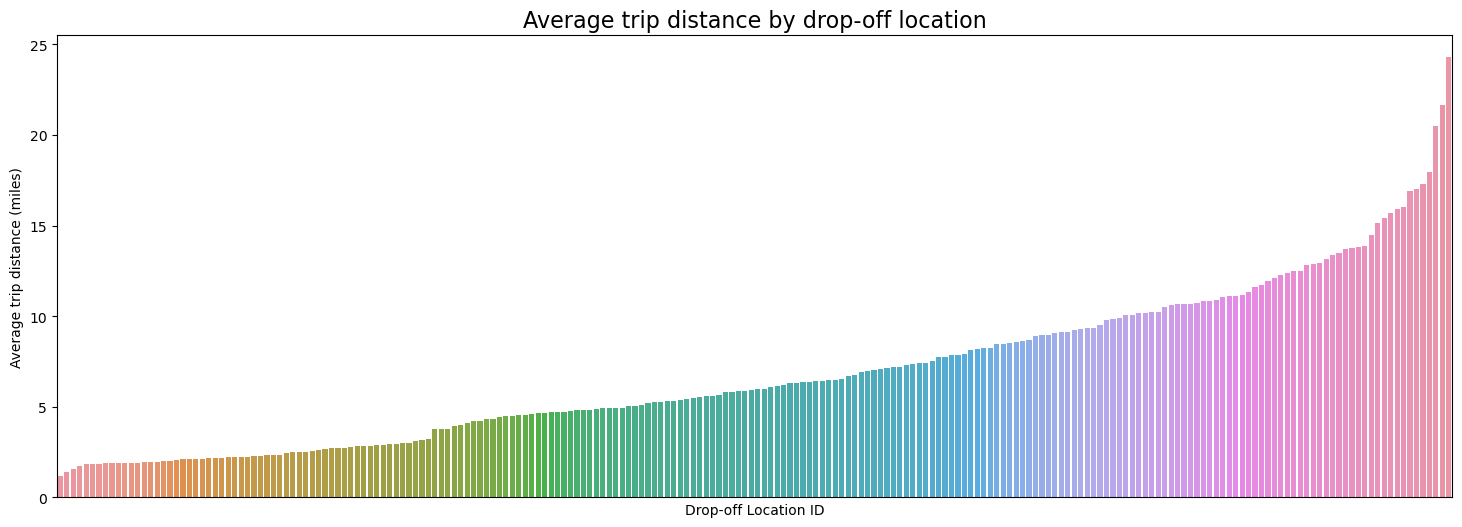

In [26]:
# Calculate the mean trip distance for each drop-off location
distance_by_dropoff = df[['DOLocationID','trip_distance']].groupby('DOLocationID').mean()

# Sort the results in ascending order by mean trip distance
distance_by_dropoff = distance_by_dropoff.sort_values(by='trip_distance')

plt.figure(figsize=(18,6))
ax = sns.barplot(x = distance_by_dropoff.index, 
                 y = distance_by_dropoff['trip_distance'], 
                 order = distance_by_dropoff.index)
ax.set_xticklabels([])
ax.set_xticks([])
plt.xlabel('Drop-off Location ID')
plt.ylabel('Average trip distance (miles)')
plt.title('Average trip distance by drop-off location', fontsize = 16)
plt.show()

This looks like the cumulative density function of a normal distribution.

To confirm this assertion, consider the following experiment:

1. Create a sample of coordinates from a normal distribution—in this case 1,500 pairs of points from a normal distribution with a mean of 10 and a standard deviation of 5
2. Calculate the distance between each pair of coordinates
3. Group the coordinates by endpoint and calculate the mean distance between that endpoint and all other points it was paired with
4. Plot the mean distance for each unique endpoint

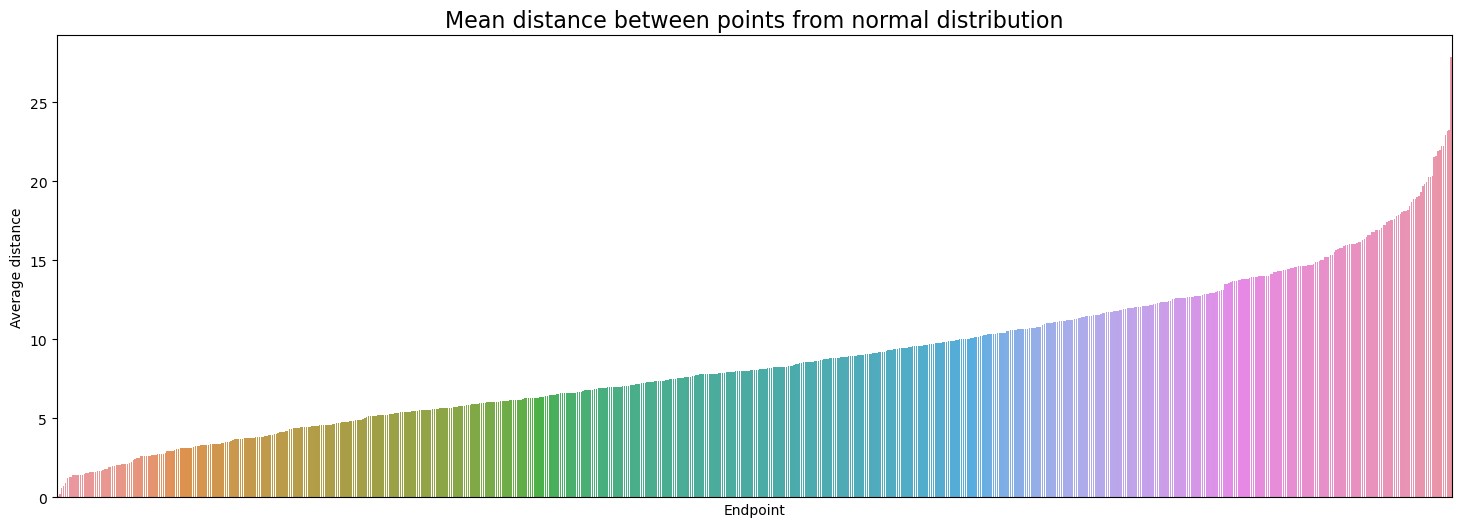

In [27]:
#1. Generate random points on a 2D plane from a normal distribution
n_pts = 1500
pts = np.random.normal(loc=10, scale=5, size=(n_pts,2))

# 2. Calculate Euclidean distances between points in first half and second half of array
halfway = int(n_pts/2)
half1 = pts[:halfway].round(1)
half2 = pts[halfway:].round(1)
distances = (half1 - half2)**2
distances = distances.sum(axis=1)
distances = np.sqrt(distances)

# 3. Group the coordinates by "drop-off location", compute mean distance
experiment_df = pd.DataFrame({'start': [tuple(x) for x in half1.tolist()],
                             'end': [tuple(x) for x in half2.tolist()],
                             'distance': distances.tolist()})

mean_dist = experiment_df[['end','distance']].groupby('end').mean().sort_values(by='distance')

# 4. Plot the mean distance between each endpoint ("drop-off location") and all points it connected to
plt.figure(figsize=(18,6))
ax = sns.barplot(x = [str(x) for x in mean_dist.index], 
                 y = mean_dist['distance'], 
                 order = [str(x) for x in mean_dist.index])
ax.set_xticklabels([])
ax.set_xticks([])
plt.xlabel('Endpoint')
plt.ylabel('Average distance')
plt.title('Mean distance between points from normal distribution', fontsize = 16)
plt.show()

**Histogram of rides by drop-off location**

First, check to whether the drop-off locations IDs are consecutively numbered. For instance, does it go 1, 2, 3, 4..., or are some numbers missing (e.g., 1, 3, 4...). If numbers aren't all consecutive, the histogram will look like some locations have very few or no rides when in reality there's no bar because there's no location.

In [28]:
# Check if all drop-off locations are consecutively numbered. Let's do this by taking the max difference between consecutive IDs
distance_by_dropoff.sort_index().index.diff().max()

5.0

We see that the drop-off locations are _not_ consecutively numbered. Here are all the unique locations sorted.

In [29]:
distance_by_dropoff.sort_index().index.values

array([  1,   4,   7,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,
        19,  21,  22,  23,  24,  25,  26,  28,  29,  31,  32,  33,  34,
        35,  36,  37,  38,  39,  40,  41,  42,  43,  45,  47,  48,  49,
        50,  51,  52,  53,  54,  55,  56,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  97,  98, 100, 102, 106, 107, 112, 113, 114, 116,
       117, 118, 119, 120, 121, 123, 124, 125, 126, 127, 129, 130, 131,
       132, 133, 134, 135, 136, 137, 138, 140, 141, 142, 143, 144, 145,
       146, 147, 148, 149, 150, 151, 152, 153, 157, 158, 159, 160, 161,
       162, 163, 164, 166, 168, 169, 170, 171, 173, 174, 175, 177, 178,
       179, 180, 181, 182, 183, 184, 186, 188, 189, 190, 192, 193, 194,
       195, 196, 197, 198, 200, 201, 202, 205, 207, 208, 209, 210, 211,
       212, 213, 215, 216, 217, 218, 219, 220, 222, 223, 224, 22

To eliminate the spaces in the historgram that these missing numbers would create, sort the unique drop-off location values, then convert them to strings. This will make the histplot function display all bars directly next to each other.

/Users/joseph/miniconda3/envs/portfolio_taxi/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


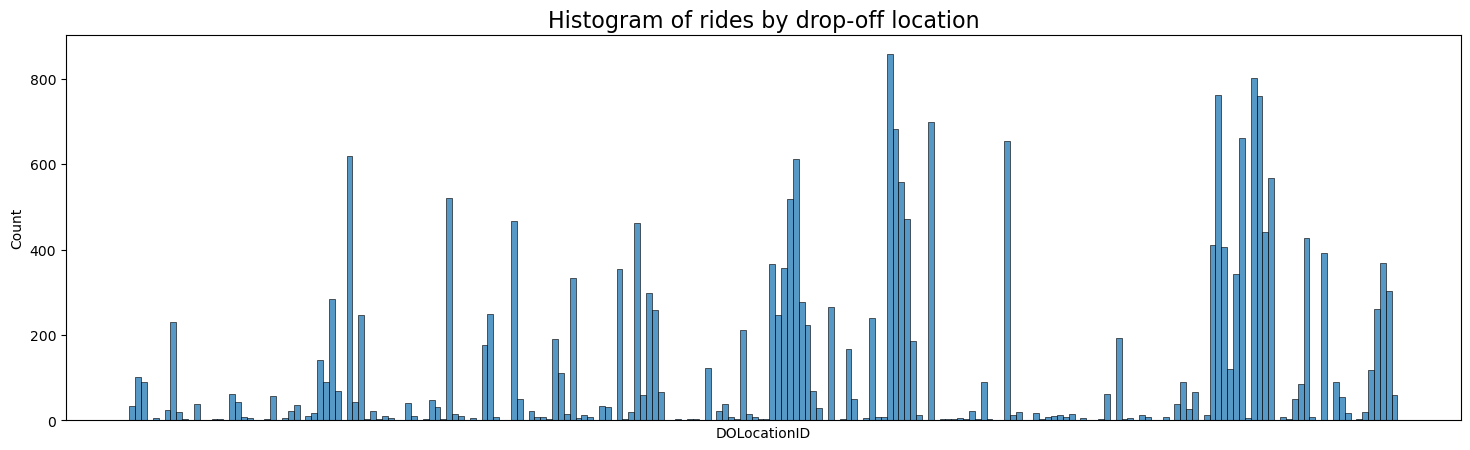

In [30]:
# DOLocationID column is numeric, so sort in ascending order
dropoffs_sorted = df['DOLocationID'].sort_values()

# Convert to string
dropoffs_sorted = dropoffs_sorted.astype('str')

# Plot
plt.figure(figsize=(18,5))
ax = sns.histplot(dropoffs_sorted)
ax.set_xticklabels([])
ax.set_xticks([])
plt.title('Histogram of rides by drop-off location', fontsize = 16)
plt.show()

We see that some locations represent over 800 rides while others are not even perceptable in the histogram. Clearly some drop-off locations are very popular; I bet the airport in one of them. Unfortunately the data does not contain the info to check this.

## A/B test <a id='AB'></a>
#### How payment method affects fare amount

**Note:** We will assume that the sample data comes from an experiment in which customers are randomly selected and divided into two groups: 1) customers who are required to pay with credit card, 2) customers who are required to pay with cash. Without this assumption, we cannot draw causal conclusions about how payment method affects fare amount.

**Question:**  Is there a relationship between payment type and fare amount? For example: do customers who use credit cards pay higher fare amounts than customers who use cash?

**Approach:** A hypothesis test (an A/B test) will be a two-sample t-test.

Recall that `payment_type` is encoded in integers:
*   1: Credit card
*   2: Cash
*   3: No charge
*   4: Dispute
*   5: Unknown

In [31]:
# Let's begin by looking at the average fare amount by each payment type
df.groupby('payment_type').agg({'fare_amount':'mean', 'payment_type':'count'})

,fare_amount,payment_type
payment_type,,
1,13.429748,15265
2,12.213546,7267
3,12.186116,121
4,9.913043,46


Based on the averages shown, it appears that customers who pay with credit card tend to pay a higher fare amount than customers who pay in cash. However, this difference might arise from random sampling rather than being a true difference in fare amount. To assess whether the difference is statistically significant, we will conduct a hypothesis test.

Recall the steps for conducting a hypothesis test: 

1.   State the null hypothesis ($H_0$) and the alternative hypothesis ($H_A$)
2.   Choose a significance level ($\alpha$)
3.   Find the p-value
4.   Reject or fail to reject the null hypothesis

**Step 1:**

$H_0$: There is no difference in the average fare amount between customers who use credit cards and customers who use cash.

$H_A$: There _is_ a difference in the average fare amount between customers who use credit cards and customers who use cash.

**Step 2:**

We choose a significance level of 0.05 or 5%. This is the threshold at which we will consider a result statistically significant. The
significance level is also the probability of rejecting the null hypothesis when it is true.

**Step 3:**

In [32]:
credit_card = df[df['payment_type'] == 1]
cash = df[df['payment_type'] == 2]

# We will conduct a two-sample t-test to determine whether two population means are equal to each other
stats.ttest_ind(a=credit_card['fare_amount'], b=cash['fare_amount'], alternative='two-sided', equal_var=False)

TtestResult(statistic=6.866800855655372, pvalue=6.797387473030518e-12, df=16675.48547403633)

**Step 4:**

Because the p-value (6.8e-12) is less (much less!) than the chosen significance level (0.05), we reject the null hypothesis. We thereby conclude that there is a statistically significant difference in the average fare amount between customers who use credit cards and customers who use cash.

Hence, the difference in average fair amount we observed earlier, whereby customers who pay with credit card tend to pay a higher fare amount than customers who pay in cash, was statistically significant. Encouraging customers to pay with credit card could generate more revenue for taxi cab drivers. 

However, recall that for the purposes of conducting this A/B test, we assumed customers were randomly assigned to two groups (credit cards or cash). But in reality, it may not be that payment type determines fare amount, it could be the other way around. For example, it could be that customers who take longer rides--which incur higher fares--are more likely to pay with credit card.

## Linear regression model <a id='regression'></a>
Build a multiple linear regression model to predict `fare_amount`. This prediction will be used as a feature for the final model that aims to predict whether or not a customer will be a generous tipper.

**Check for missing data and duplicates**

In [33]:
# Is there any missing data?
print('Total count of missing values:', df.isna().sum().sum())

# Are there duplicate rows?
print('Initial number of rows before dropping duplicates:', df.shape[0])
df = df.drop_duplicates()
print('Final number of rows after dropping duplicates:', df.shape[0])

Total count of missing values: 0
Initial number of rows before dropping duplicates: 22699
Final number of rows after dropping duplicates: 22699


Thus, there are no missing data or duplicate rows.

**Create `duration` column**

In [34]:
# Create a new column called duration that represents the total number of minutes that each taxi ride took
df['duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.seconds/60

# View it
df[['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'duration']].head(3)

,tpep_pickup_datetime,tpep_dropoff_datetime,duration
0,2017-03-25 08:55:43,2017-03-25 09:09:47,14.066667
1,2017-04-11 14:53:28,2017-04-11 15:19:58,26.500000
2,2017-12-15 07:26:56,2017-12-15 07:34:08,7.200000


### Outliers <a id='outliers'></a>

Let's check for outliers in the following columns:
- trip_distance
- fare_amount
- duration

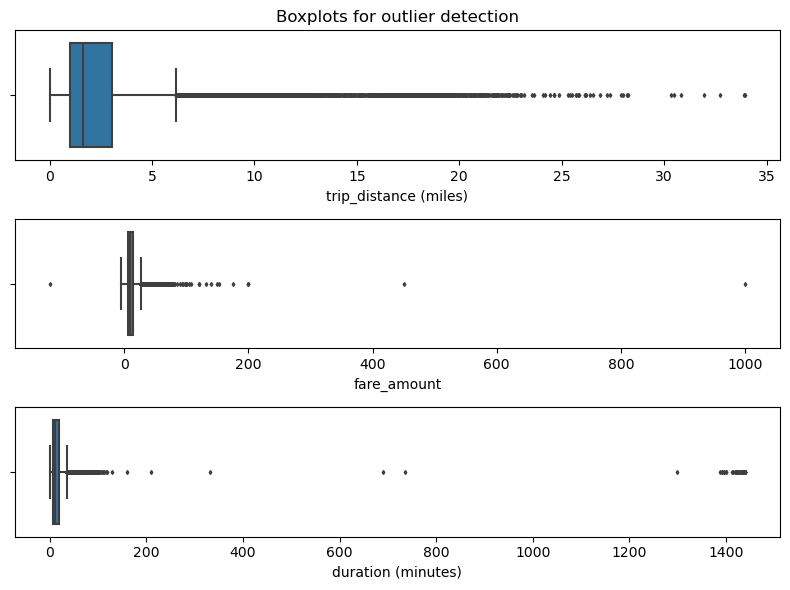

In [35]:
# Create boxplots
fig, axes = plt.subplots(3,1, figsize = (8,6))
sns.boxplot(x=df['trip_distance'], fliersize=2, ax=axes[0])
sns.boxplot(x=df['fare_amount'], fliersize=2, ax=axes[1])
sns.boxplot(x=df['duration'], fliersize=2, ax=axes[2])

axes[0].set_xlabel('trip_distance (miles)')
axes[2].set_xlabel('duration (minutes)')

axes[0].set_title('Boxplots for outlier detection')

plt.tight_layout()
plt.show()

We see that all three variables contain outliers, and some are very extreme.

`Trip distance` seems alright considering that the outliers are under 35 miles which is a reasonable distance. Furthermore, there is a steady progression of outliers extending to the maximum distance, making them likely legitimate.

`Fare_amount` and `duration` have some extreme outliers on the higher end that seem erroneous. On the lower end, a negative fare amount makes no sense.

### Imputations <a id='impute'></a>

***`trip_distance` outliers***

We know from the summary statistics that there are trip distances of zero. Let's determine whether these values are erroneous or simply very short trips rounded down. To do this, let's check the precision of these values.

In [36]:
# What is the precision of these trip distances of zero?
df['trip_distance'].sort_values()[0:10]

22026    0.0
795      0.0
6908     0.0
13561    0.0
12238    0.0
6878     0.0
14372    0.0
20638    0.0
920      0.0
16263    0.0
Name: trip_distance, dtype: float64

There is a high degree of precision, namely in 0.1 mile increments. There are about 20 blocks per mile in NYC, so this precision is equates to 2 NYC-blocks. We can therefore assume that these 0.0 values are not just short trips rounded down. Perhaps they are instead due to passengers summoning taxis and then changing their minds. Are there enough of these values in the dataset to pose a problem?

In [37]:
# How many 0.0 mile trips are there?
(df['trip_distance'] == 0).sum()

148

There aren't many rides where trip distance is zero, so let's leave them.

**`fare_amount` outliers**

In [38]:
df['fare_amount'].describe()

count    22699.000000
mean        13.026629
std         13.243791
min       -120.000000
25%          6.500000
50%          9.500000
75%         14.500000
max        999.990000
Name: fare_amount, dtype: float64

There do seem to be outliers on both the low and high end:
- **Low values:** Negative values don't make any sense. Values of zero are possible if, as with trip_distance, they represent instances where a customer summons a taxi and then changes their mind. Let's impose a lower cap of 0.
- **High values:** A fare amount of $\$1,000$ seems highly unlikely. The standard threshold formula for outliers on the high end is $Q3 + (1.5 * IQR)$, where the interquartile range (IQR) is 8.0 (ie, 14.5 - 6.5), and the formula gives $14.5+(1.5*8.0) = \$26.5$. However, intuition says that this maximum fare cap is too low. Use a larger factor instead such as 6, which results in an upper cap of $\$62.5$.

The following function accomplishes these tasks:
- Impute min as 0
- Impute max as `Q3 + (6 * IQR)`

In [39]:
def impute_outliers(column_list, iqr_factor):
    '''
    Impute upper-limit values in specified columns based on their interquartile range.

    Arguments:
        column_list: A list of columns to iterate over
        iqr_factor: A number representing x in the formula:
                    Q3 + (x * IQR). Used to determine maximum threshold,
                    beyond which a point is considered an outlier.

    The IQR is computed for each column in column_list and values exceeding
    the upper threshold for each column are imputed with the upper threshold value.
    '''
    for column in column_list:
        # Reassign minimum to zero
        df.loc[df[column] < 0, column] = 0

        # Calculate upper threshold
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        IQR = q3 - q1
        upper_threshold = q3 + iqr_factor*IQR
        print('Upper threshold is {:.1f} for column {}'.format(upper_threshold, column))

        # Reassign values > threshold to threshold
        df.loc[df[column] > upper_threshold, column] = upper_threshold

        print(df[column].describe())
        print()

In [40]:
# Impute outliers for fare_amount
impute_outliers(['fare_amount'], 6)

Upper threshold is 62.5 for column fare_amount
count    22699.000000
mean        12.897913
std         10.541137
min          0.000000
25%          6.500000
50%          9.500000
75%         14.500000
max         62.500000
Name: fare_amount, dtype: float64



**`duration` outliers**

In [41]:
df['duration'].describe()

count    22699.000000
mean        17.077216
std         62.694515
min          0.000000
25%          6.650000
50%         11.183333
75%         18.383333
max       1439.550000
Name: duration, dtype: float64

The duration column has problematic values at both the lower and upper extremities.
- **Low values:** There should be no values that represent negative time. Impute all negative durations with 0.
- **High values:** Impute high values the same way we imputed the high-end outliers for fares: Q3 + (6 * IQR).

In [42]:
# Impute outliers for duration
impute_outliers(['duration'], 6)

Upper threshold is 88.8 for column duration
count    22699.000000
mean        14.464466
std         11.956838
min          0.000000
25%          6.650000
50%         11.183333
75%         18.383333
max         88.783333
Name: duration, dtype: float64



### Feature engineering <a id='lm_engineering'></a>

**Create `mean_distance` column**

We cannot train a model on the trip_distance feature because that is unknown until _after_ the trip occurs. However, we can use the statistics of trips to generalize about new ones. Specifically, we can take all pairs of pickup and dropoff locations, find the average trip distance between them, and use this new feature called `mean_distance` to train a model.

In [43]:
# Create pickup_dropoff column
df['pickup_dropoff'] = df['PULocationID'].astype('string') + ' ' + df['DOLocationID'].astype('string')

# Compute the mean of each row for trip_distance
grouped = df[['pickup_dropoff', 'trip_distance']].groupby(['pickup_dropoff']).mean()
grouped.head()

,trip_distance
pickup_dropoff,
1 1,2.433333
10 148,15.700000
100 1,16.890000
100 100,0.253333
100 107,1.180000


In [44]:
# Convert "grouped" to a dictionary so we can use it as a lookup
grouped_dict = grouped.to_dict()

# Reassign to only contain the inner dictionary
grouped_dict = grouped_dict['trip_distance']

# Create a mean_distance column that is a copy of the pickup_dropoff helper column
df['mean_distance'] = df['pickup_dropoff']

# Map grouped_dict to the mean_distance column
df['mean_distance'] = df['mean_distance'].map(grouped_dict)

# Confirm that it worked
df[(df['PULocationID'] == 100) & (df['DOLocationID'] == 231)][['PULocationID', 'DOLocationID', 'trip_distance', 'mean_distance']]

,PULocationID,DOLocationID,trip_distance,mean_distance
0,100,231,3.34,3.521667
4909,100,231,2.79,3.521667
16636,100,231,3.70,3.521667
18134,100,231,4.10,3.521667
19761,100,231,3.10,3.521667
20581,100,231,4.10,3.521667


**Create `mean_duration` column**

Repeat the above process.

In [45]:
grouped = df[['pickup_dropoff', 'duration']].groupby(['pickup_dropoff']).mean()

# Create a dictionary where keys are unique pickup_dropoffs and values are
# mean trip duration for all trips with those pickup_dropoff combos
grouped_dict = grouped.to_dict()
grouped_dict = grouped_dict['duration']

df['mean_duration'] = df['pickup_dropoff']
df['mean_duration'] = df['mean_duration'].map(grouped_dict)

# Confirm that it worked
df[(df['PULocationID'] == 100) & (df['DOLocationID'] == 231)][['PULocationID', 'DOLocationID', 'trip_distance', 'mean_duration']]

,PULocationID,DOLocationID,trip_distance,mean_duration
0,100,231,3.34,22.847222
4909,100,231,2.79,22.847222
16636,100,231,3.70,22.847222
18134,100,231,4.10,22.847222
19761,100,231,3.10,22.847222
20581,100,231,4.10,22.847222


**Create `rush_hour` column**

Define rush hour as:
- Any weekday (not Saturday or Sunday) AND
- Either from 06:00–10:00 or from 16:00–20:00

Create a binary rush_hour column that contains a 1 if the ride was during rush hour and a 0 if it was not.

In [46]:
# Create binary rush_hour column:

# Extract the hour
hourofday = df['tpep_pickup_datetime'].dt.hour 

# Get booleans for rush hour in the morning and evening
rush_morning = (hourofday >= 6) & (hourofday < 10) # rush hour [6am to 10am)
rush_evening = (hourofday >= 16) & (hourofday < 20) # rush hour [4pm to 8pm)

# Apply full logic as defined earlier
df['rush_hour'] = (~df['day'].isin(['saturday', 'sunday'])) & (rush_morning | rush_evening)

# Convert from boolean to binary
df['rush_hour'] = df['rush_hour'].astype('int') 

# Confirm that it worked
df[['tpep_pickup_datetime', 'day', 'rush_hour']].head()

,tpep_pickup_datetime,day,rush_hour
0,2017-03-25 08:55:43,saturday,0
1,2017-04-11 14:53:28,tuesday,0
2,2017-12-15 07:26:56,friday,1
3,2017-05-07 13:17:59,sunday,0
4,2017-04-15 23:32:20,saturday,0


In [47]:
# Another way to create this feature

# # Initialize rush_hour column with hour values
# df['rush_hour'] = df['tpep_pickup_datetime'].dt.hour

# # Define function
# def rush_hourizer(df):
#     if 6 <= df['rush_hour'] < 10:
#         val = 1
#     elif 16 <= df['rush_hour'] < 20:
#         val = 1
#     else:
#         val = 0
#     return val

# # Apply the function to the new column
# df['rush_hour'] = df.apply(rush_hourizer, axis=1)

# # Set values to 0 if on the weekend
# df.loc[df['day'].isin(['saturday','sunday']), 'rush_hour'] = 0

# # Confirm that it worked
# df[['tpep_pickup_datetime', 'day', 'rush_hour']].head(10)

### Further EDA <a id='lm_eda'></a>
#### Scatter plot

Visualize the relationship between `mean_duration` and `fare_amount`

In [48]:
df.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,month,day,duration,pickup_dropoff,mean_distance,mean_duration,rush_hour
0,24870114,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56,mar,saturday,14.066667,100 231,3.521667,22.847222,0
1,35634249,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80,apr,tuesday,26.500000,186 43,3.108889,24.470370,0
2,106203690,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75,dec,friday,7.200000,262 236,0.881429,7.250000,1
3,38942136,2,2017-05-07 13:17:59,2017-05-07 13:48:14,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69,may,sunday,30.250000,188 97,3.700000,30.250000,0
4,30841670,2,2017-04-15 23:32:20,2017-04-15 23:49:03,1,4.37,1,N,4,112,2,16.5,0.5,0.5,0.00,0.0,0.3,17.80,apr,saturday,16.716667,4 112,4.435000,14.616667,0


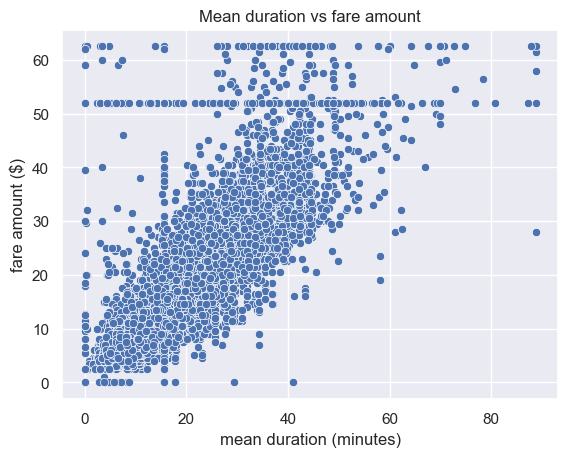

In [49]:
# Create the scatterplot
sns.set(style='darkgrid')
sns.scatterplot(data=df, x='mean_duration', y='fare_amount')
plt.xlabel('mean duration (minutes)')
plt.ylabel('fare amount ($)')
plt.title('Mean duration vs fare amount')
plt.show()

Three things stand out from this scatter plot:
- The `mean_duration` variable correlates with our target variable, `fare_amount`.
- There is a horizontal line just above $\$50$
- And another horizontal line just above $\$60$.
    - This line is from imputing large outliers; it is at $\$62.5$.

The other horizontal line requires further investigation.

In [50]:
# Find the frequent value that is just above $50
df.loc[df['fare_amount'] > 50, 'fare_amount'].value_counts().head()

fare_amount
52.0    514
62.5     84
59.0      9
50.5      9
57.5      8
Name: count, dtype: int64

The horizontal line just above 50 is clearly at 52.

In [51]:
# Examine the first 30 of these trips where fare_amount is $52
df[df['fare_amount'] == 52].head(30)

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,month,day,duration,pickup_dropoff,mean_distance,mean_duration,rush_hour
11,18600059,2,2017-03-05 19:15:30,2017-03-05 19:52:18,2,18.90,2,N,236,132,1,52.0,0.0,0.5,14.58,5.54,0.3,72.92,mar,sunday,36.800000,236 132,19.211667,40.500000,0
110,47959795,1,2017-06-03 14:24:57,2017-06-03 15:31:48,1,18.00,2,N,132,163,1,52.0,0.0,0.5,0.00,0.00,0.3,52.80,jun,saturday,66.850000,132 163,19.229000,52.941667,0
161,95729204,2,2017-11-11 20:16:16,2017-11-11 20:17:14,1,0.23,2,N,132,132,2,52.0,0.0,0.5,0.00,0.00,0.3,52.80,nov,saturday,0.966667,132 132,2.255862,3.021839,0
247,103404868,2,2017-12-06 23:37:08,2017-12-07 00:06:19,1,18.93,2,N,132,79,2,52.0,0.0,0.5,0.00,0.00,0.3,52.80,dec,wednesday,29.183333,132 79,19.431667,47.275000,0
379,80479432,2,2017-09-24 23:45:45,2017-09-25 00:15:14,1,17.99,2,N,132,234,1,52.0,0.0,0.5,14.64,5.76,0.3,73.20,sep,sunday,29.483333,132 234,17.654000,49.833333,0
388,16226157,1,2017-02-28 18:30:05,2017-02-28 19:09:55,1,18.40,2,N,132,48,2,52.0,4.5,0.5,0.00,5.54,0.3,62.84,feb,tuesday,39.833333,132 48,18.761905,58.246032,1
406,55253442,2,2017-06-05 12:51:58,2017-06-05 13:07:35,1,4.73,2,N,228,88,2,52.0,0.0,0.5,0.00,5.76,0.3,58.56,jun,monday,15.616667,228 88,4.730000,15.616667,0
449,65900029,2,2017-08-03 22:47:14,2017-08-03 23:32:41,2,18.21,2,N,132,48,2,52.0,0.0,0.5,0.00,5.76,0.3,58.56,aug,thursday,45.450000,132 48,18.761905,58.246032,0
468,80904240,2,2017-09-26 13:48:26,2017-09-26 14:31:17,1,17.27,2,N,186,132,2,52.0,0.0,0.5,0.00,5.76,0.3,58.56,sep,tuesday,42.850000,186 132,17.096000,42.920000,0
520,33706214,2,2017-04-23 21:34:48,2017-04-23 22:46:23,6,18.34,2,N,132,148,1,52.0,0.0,0.5,5.00,0.00,0.3,57.80,apr,sunday,71.583333,132 148,17.994286,46.340476,0


In [52]:
# It appears that RatecodeID is held constant. Let's see.
df.loc[df['fare_amount'] == 52, 'RatecodeID'].value_counts()

RatecodeID
2    513
1      1
Name: count, dtype: int64

This frequent fare amount of $52 has RatecodeID = 2 which means these are trips to the JFK airport (according to the data dictionary). There must be a flat rate to the airport which is why they all have the same value.

After the model makes its predictions for `fare_amount`, we could impute this flat fee back into the data when `RatecodeID` is 2. It is good practice not to train a model on data we don't need a model for anyway, so let's remove all rides where `RatecodeID` is 2.

#### Remove rides where RatecodeID is 2

We will impute these values after the model has made its predictions.

In [53]:
# Initial count of rows for sanity check
rows_before = df.shape[0]

# Get index of rows where RatecodeID = 2
drop_idx = df[df['RatecodeID'] == 2].index

# Save these rows elsewhere for later
df_saved_rows = df.iloc[drop_idx]

# Drop these rows
df.drop(index=drop_idx, inplace=True)

# Sanity check
print('%i rows were removed' % (rows_before - df.shape[0]))

513 rows were removed


#### Isolate modeling variables

Drop features that are redundant, irrelevant, or that will not be available in a deployed environment. Recall that `fare_amount` is the target.

In [54]:
df1 = df.drop(columns=['Unnamed: 0', 'tpep_pickup_datetime','tpep_dropoff_datetime', 'trip_distance', 'store_and_fwd_flag', 
                       'PULocationID', 'DOLocationID', 'payment_type', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
                       'improvement_surcharge', 'total_amount', 'duration', 'pickup_dropoff', 'month', 'day'])

In [55]:
df1.head()

,VendorID,passenger_count,RatecodeID,fare_amount,mean_distance,mean_duration,rush_hour
0,2,6,1,13.0,3.521667,22.847222,0
1,1,1,1,16.0,3.108889,24.470370,0
2,1,1,1,6.5,0.881429,7.250000,1
3,2,1,1,20.5,3.700000,30.250000,0
4,2,1,1,16.5,4.435000,14.616667,0


#### Pair plot

To visualize the pairwise relationships between variables

In [56]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22186 entries, 0 to 22698
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   VendorID         22186 non-null  int64  
 1   passenger_count  22186 non-null  int64  
 2   RatecodeID       22186 non-null  int64  
 3   fare_amount      22186 non-null  float64
 4   mean_distance    22186 non-null  float64
 5   mean_duration    22186 non-null  float64
 6   rush_hour        22186 non-null  int64  
dtypes: float64(3), int64(4)
memory usage: 1.4 MB


/Users/joseph/miniconda3/envs/portfolio_taxi/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/joseph/miniconda3/envs/portfolio_taxi/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/joseph/miniconda3/envs/portfolio_taxi/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


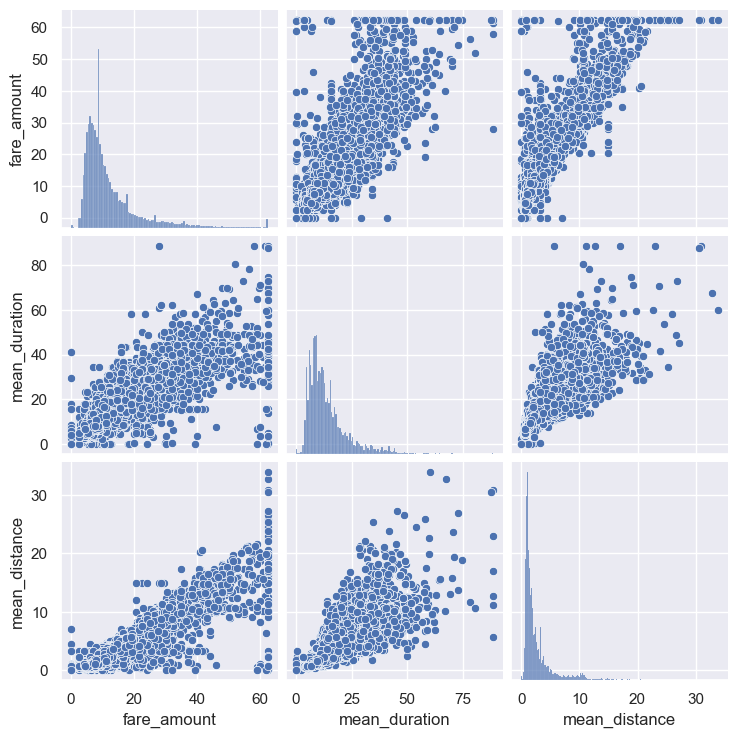

In [57]:
# Create a pairplot to visualize pairwise relationships between the continuous variables
sns.pairplot(df1[['fare_amount', 'mean_duration', 'mean_distance']])
plt.show()

These variables all show linear correlation with each other. Investigate this further with a correlation matrix to help determine the most correlated variables.

In [58]:
df1.corr(numeric_only=True)

,VendorID,passenger_count,RatecodeID,fare_amount,mean_distance,mean_duration,rush_hour
VendorID,1.000000,0.267588,-0.004692,-0.003935,0.000615,-0.002714,-0.002814
passenger_count,0.267588,1.000000,-0.007428,0.013443,0.012436,0.014013,-0.023046
RatecodeID,-0.004692,-0.007428,1.000000,0.131502,0.051901,0.021952,0.005919
fare_amount,-0.003935,0.013443,0.131502,1.000000,0.904079,0.847472,-0.027184
mean_distance,0.000615,0.012436,0.051901,0.904079,1.000000,0.846275,-0.055347
mean_duration,-0.002714,0.014013,0.021952,0.847472,0.846275,1.000000,-0.030880
rush_hour,-0.002814,-0.023046,0.005919,-0.027184,-0.055347,-0.030880,1.000000


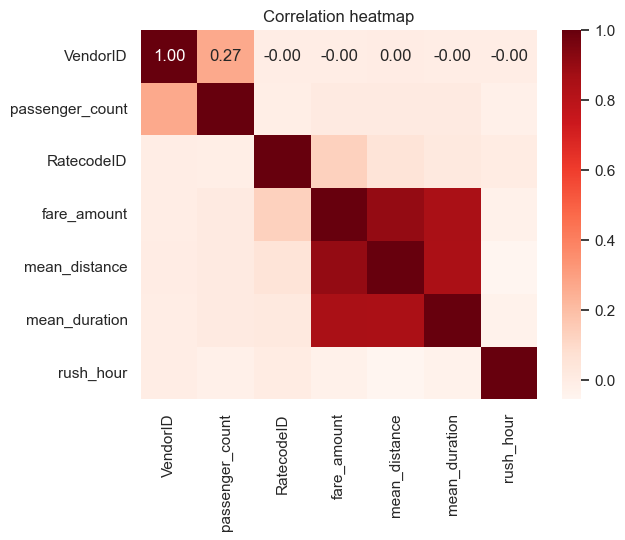

In [59]:
# Visualize a correlation heatmap of the data
sns.heatmap(df1.corr(numeric_only=True), annot=True, fmt='.2f', cmap='Reds')
plt.title('Correlation heatmap')
plt.show()

`mean_distance` and `mean_duration` are each highly correlated with the target variable `fare_amount`, so they will be the best predictors. They are also highly correlated with each other, having a Pearson correlation coefficient of 0.85. This multicollinearity would be a problem--and we would likely remove either mean_distance or mean_duration--if we were interested in interpretation of model results. But here our aim is to perform multiple linear regression to create a feature, `predicted_fare`, to then use in the final model to predict whether a customer will be a generous tipper. Because we don't care about using the model to learn about the data, we can ignore this multicollinearity and just try to create an accurate predictor.

### Prepare data for modeling <a id='lm_prep'></a>
#### Split data into outcome variable and features

In [60]:
# Isolate target variable (y)
y = df1[['fare_amount']]

# Isolate features (X)
X = df1.drop(columns='fare_amount')

# Display first few rows
X.head()

,VendorID,passenger_count,RatecodeID,mean_distance,mean_duration,rush_hour
0,2,6,1,3.521667,22.847222,0
1,1,1,1,3.108889,24.470370,0
2,1,1,1,0.881429,7.250000,1
3,2,1,1,3.700000,30.250000,0
4,2,1,1,4.435000,14.616667,0


#### Pre-process the data

Dummy encode categorical variables 

In [61]:
# Convert VendorID and RatecodeID to string
X['VendorID'] = X['VendorID'].astype('string')
X['RatecodeID'] = X['RatecodeID'].astype('string')

# Get dummies
X = pd.get_dummies(X, drop_first=True)
X.head()

,passenger_count,mean_distance,mean_duration,rush_hour,VendorID_2,RatecodeID_3,RatecodeID_4,RatecodeID_5,RatecodeID_99
0,6,3.521667,22.847222,0,True,False,False,False,False
1,1,3.108889,24.470370,0,False,False,False,False,False
2,1,0.881429,7.250000,1,False,False,False,False,False
3,1,3.700000,30.250000,0,True,False,False,False,False
4,1,4.435000,14.616667,0,True,False,False,False,False


#### Split data into training and test sets

Create training and testing sets. The test set should contain 20% of the total samples.

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

#### Standardize the data

The `StandardScaler` function scales each point $x_i$ by subtracting the mean observed value for that feature and dividing by the standard deviation:
$$
x_{scaled} = \frac{x_i - \overline{X}}{\sigma}
$$

In [63]:
# Standardize the X variables so each feature has a mean of 0 and standard deviation of 1
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
print(X_train_scaled)

[[-0.49798663  0.38027303  0.9622193  ... -0.02123578 -0.05626075
  -0.0075065 ]
 [ 1.83318974 -0.30430255 -0.54194192 ... -0.02123578 -0.05626075
  -0.0075065 ]
 [-0.49798663 -0.05419356 -0.18178303 ... -0.02123578 -0.05626075
  -0.0075065 ]
 ...
 [-0.49798663 -0.57027071 -0.14967576 ... -0.02123578 -0.05626075
  -0.0075065 ]
 [-0.49798663 -0.49627124 -0.32676568 ... -0.02123578 -0.05626075
  -0.0075065 ]
 [-0.49798663  2.31340622  0.84760281 ... -0.02123578 -0.05626075
  -0.0075065 ]]


#### Fit the model <a id='lm_fit'></a>

In [64]:
# Instantiate model
lr_model = LinearRegression()

# Fit your model to the training data
lr_model.fit(X_train_scaled, y_train)

LinearRegression()

#### Evaluate model <a id="lm_eval"></a>

Evaluate model performance by calculating the explained variance score ($R^2$),  Mean Absolute Error (MAE), Mean Squared Error (MSE), and the Root Mean Squared Error (RMSE).

In [65]:
def evaluate_model(y_true, y_pred):
    '''
    Helper function to calculate the following four metrics
    '''
    print('Explained variance score (R^2): %.2f' % metrics.r2_score(y_true, y_pred))
    print('Mean Absolute Error (MAE): %.2f' % metrics.mean_absolute_error(y_true, y_pred))
    print('Mean Squared Error (MSE): %.2f' % metrics.mean_squared_error(y_true, y_pred))
    print('Root Mean Square Error (RMSE): %.2f' % np.sqrt(metrics.mean_squared_error(y_true, y_pred)))

**Train data**

In [66]:
# Evaluate the model performance on the training data
evaluate_model(y_train, lr_model.predict(X_train_scaled))

Explained variance score (R^2): 0.87
Mean Absolute Error (MAE): 1.93
Mean Squared Error (MSE): 9.92
Root Mean Square Error (RMSE): 3.15


**Test data**

In [67]:
# Scale the X_test data
X_test_scaled = scaler.transform(X_test)

# Evaluate the model performance on the testing data
y_pred_test = lr_model.predict(X_test_scaled)
evaluate_model(y_test, y_pred_test)

Explained variance score (R^2): 0.86
Mean Absolute Error (MAE): 1.95
Mean Squared Error (MSE): 10.37
Root Mean Square Error (RMSE): 3.22


The model performance is similarly high on both the training and test sets, suggesting that the model has neither high bias (ie, underfit to training data) nor high variance (ie, overfit to training data). In other words, the model has both low bias and low variance and thereby performs well.

For the test data, an $R^2$ of 0.86 means that about 86% of the variance in `fare_amount` is captured by the model. This is great.

**Visualize model results**

In [68]:
# Get actual, predicted, and residual for the testing set, and store them in a dataframe

lr_results = pd.DataFrame({'actual': y_test['fare_amount'],
                           'predicted': y_pred_test.ravel()})

lr_results['residual'] = lr_results['actual'] - lr_results['predicted']
lr_results.head()

,actual,predicted,residual
18484,10.0,9.854293,0.145707
10872,4.0,4.937648,-0.937648
15776,13.5,7.333792,6.166208
13639,9.5,9.723819,-0.223819
18446,12.5,6.421290,6.078710


Create a scatterplot to visualize `actual` vs. `predicted`.

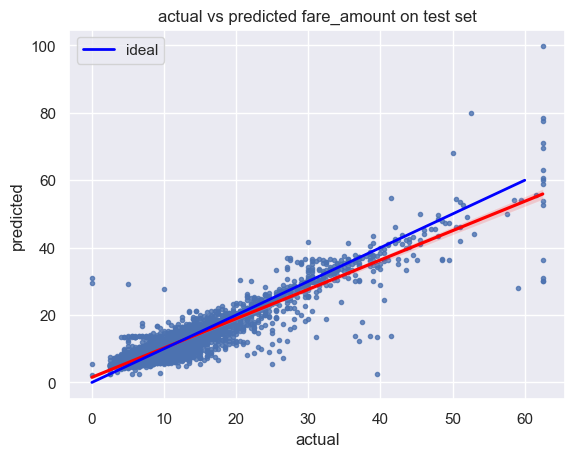

In [69]:
# sns.scatterplot(x = lr_results['actual'], y = lr_results['predicted'])
ax = sns.regplot(x = lr_results['actual'], y = lr_results['predicted'], marker='.', line_kws=dict(color='red'))

# Draw an x=y line to show what the results would be if the model were perfect
plt.plot([0,60], [0,60], c='blue', linewidth=2, label='ideal')
ax.legend()

plt.title('actual vs predicted fare_amount on test set')
plt.show()

Visualize the distribution of the `residuals` using a histogram

/Users/joseph/miniconda3/envs/portfolio_taxi/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


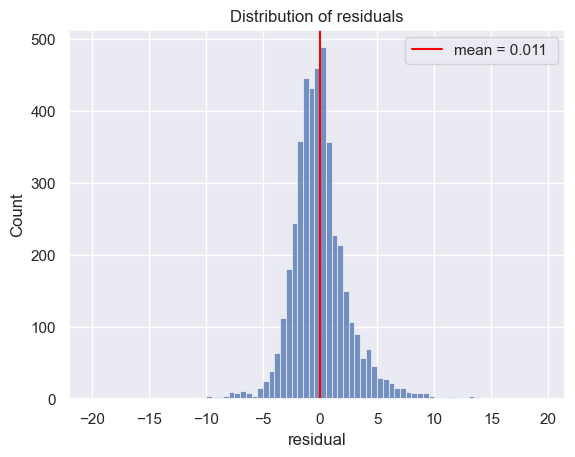

In [70]:
# Mean of residuals to annotate plot
resid_mean = lr_results['residual'].mean()

# Create histogram
ax = sns.histplot(lr_results['residual'], bins=np.arange(-20,20,0.5));
ax.axvline(resid_mean, ls='-', color='red', label='mean = %.3f ' % resid_mean)
ax.legend()
plt.title('Distribution of residuals')
plt.show()

The residuals represent the variance in the target variable that is not captured by the model. The distribution of residuals is approximately normal (thereby satisfying the normality assumption for linear regression). They are centered around zero which indicates that the model's errors are evenly distributed and unbiased (thereby satisfying the homoscedasticity assumption). 

Create a scatterplot of `residuals` over `predicted`.

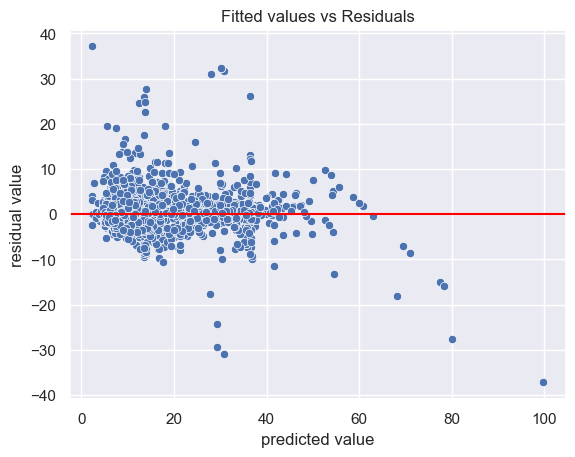

In [71]:
# Create a scatterplot of `residuals` over `predicted`
sns.scatterplot(x=lr_results['predicted'], y=lr_results['residual'])
plt.axhline(0, c='red')
plt.xlabel('predicted value')
plt.ylabel('residual value')
plt.title('Fitted values vs Residuals')
plt.show()

This plot checks the homoscedasticity assumption to see if the variation of errors in constant or similar across the model. This assumption is met because the residuals are evenly distributed above and below zero, with the exception of the sloping line that, as we know, represents the imputed max of $\$62.50$.

**Coefficients**

In [72]:
lr_model_coef = pd.DataFrame(lr_model.coef_, columns=X.columns)
lr_model_coef

,passenger_count,mean_distance,mean_duration,rush_hour,VendorID_2,RatecodeID_3,RatecodeID_4,RatecodeID_5,RatecodeID_99
0,0.039283,5.437378,2.816076,0.147377,-0.036998,0.543165,0.124162,1.416481,0.365212


Because we standardized the predictor variables, the relative magnitude of their coefficients indicates their weight in the model. We see that `mean_distance` and `mean_duration` have the largest affect. 

As an example, we can interpret the `mean_distance` coefficient as follows: controlling for other variables, for every unit increase in standard deviation (of mean_distance), the fare amount increases by an average of $\$5.44$. To make this coefficient more meaningful to interpret, we can unscale it to return to units of miles as follows:

In [73]:
# Calculate standard deviation of mean_distance
sigma = X_test['mean_distance'].std()
print('Standard deviation: %.2f' % sigma)

# Divide the model coefficient by it
print('Unscaled mean_distance coefficient: %.2f' % (lr_model_coef.loc[0, 'mean_distance'] / sigma))

Standard deviation: 2.75
Unscaled mean_distance coefficient: 1.98


Now the interpretation becomes more intuitive: 
- for every 2.75 miles traveled, the fare increased by an average of $\$5.44$. Or
- for every mile traveled, the fare increased by an average of $\$1.98$

However, recall that, due to the multicollinearity of features used in this model, any interpretation of these model results is inherently innacurate. Hence, the prior interpretation was for pedagogical purposes.

#### Prepare data for next model

To prepare the fare_amount prediction for input into the upcoming model, the following work is necessary:
1. Predict on full dataset
2. Impute constant fare rate of $52 for trips with `RatecodeID` = 2
3. Check model's performance

**Predict on entire dataset**

In [74]:
# Predict on entire dataset
X_scaled = scaler.transform(X)
y_pred = lr_model.predict(X_scaled)

**Impute fare of $52 when RatecodeID is 2**

We will add this `predicted_fare` feature to the original dataset, append the rows that were removed because their RatecodeID was 2, and then impute.

In [75]:
# Add predicted_fare column
df['predicted_fare'] = y_pred

# Append excluded rows where RatecodeID is 2
df = pd.concat([df, df_saved_rows], axis=0)

# Sort the index so it is in order again
df = df.sort_index()

# Impute a prediction of 52 at all rows where RatecodeID is 2
df.loc[df['RatecodeID']==2, 'predicted_fare'] = 52

# Sanity check
print(df.shape, ' rows,columns')
print()
print('%i missing values' % df.isna().sum().sum())
print()
print('Value counts when RatecodeID == 2:')
df.loc[df['RatecodeID']==2, 'predicted_fare'].value_counts()

(22699, 26)  rows,columns

0 missing values

Value counts when RatecodeID == 2:


predicted_fare
52.0    513
Name: count, dtype: int64

**Check performance on full dataset**

In [76]:
# Model performance after imputation
evaluate_model(df['fare_amount'], df['predicted_fare'])

Explained variance score (R^2): 0.91
Mean Absolute Error (MAE): 1.89
Mean Squared Error (MSE): 9.78
Root Mean Square Error (RMSE): 3.13


No surpise that imputation improved model performance, raising it from an $R^2$ of 0.87 to 0.91.

**Save modified dataset to csv file**

In [77]:
# df.to_csv("data/2017_Yellow_Taxi_Trip_Data_modified.csv")

#### Notes <a id="lm_notes"></a>

To recap, the following features were created for the downstream model: `mean_distance`, `mean_duration`, and `predicted_fare`, the latter of which was created using a multiple linear regression model.

There was some **data leakage** because `mean_distance` and `mean_duration` were computed using the entire dataset, a fraction of which became the test set later on. Hence, the test set did not represent entirely new, unseen data. Ideally, these engineered features would have been calculated using just the training set and then transferred to the testing set. However, this could have been problematic if any of the dropoff-pickup locations failed to appear in the training set, so, for simplicity, this data leakage was not prevented.

## More feature engineering <a id='engineering'></a>

In [78]:
# View the right side of the dataframe to see the features we created
df.head().iloc[:,-10:]

,improvement_surcharge,total_amount,month,day,duration,pickup_dropoff,mean_distance,mean_duration,rush_hour,predicted_fare
0,0.3,16.56,mar,saturday,14.066667,100 231,3.521667,22.847222,0,16.579174
1,0.3,20.80,apr,tuesday,26.500000,186 43,3.108889,24.470370,0,16.222725
2,0.3,8.75,dec,friday,7.200000,262 236,0.881429,7.250000,1,6.737863
3,0.3,27.69,may,sunday,30.250000,188 97,3.700000,30.250000,0,19.137803
4,0.3,17.80,apr,saturday,16.716667,4 112,4.435000,14.616667,0,15.558938


We know from initial EDA that tips are not recorded for customers who pay in cash. To meet the modeling objective, we need to subset the data to customers who pay with credit card.

In [79]:
# Subset the data to isolate only customers who paid by credit card
dfcc = df[df['payment_type'] == 1]

**Target**

We need to engineer a column that indicates tip percent as follows:
$$
tip \% = \frac{tip}{total - tip}
$$
The result will be a floating-point number that we must then round. This is an important step because the precision that floats allow can sometimes cause a calculation that should result in a precise value (eg, 1.1 + 2.2) be inprecise (3.3000000000000003) due to the last decimal point. Therefore, whenever a number is computed that is then used to make an important decision, round the number.

In [80]:
# Create tip % col 
tip_percent = dfcc['tip_amount'] / (dfcc['total_amount'] - dfcc['tip_amount'])
dfcc.loc[:, ['tip_percent']] = round(tip_percent, 3)

Now create another column called `generous` that will be our target variable. This column will be a binary indicator of whether or not a customer tipped $\ge$ 20% (0=no, 1=yes).

In [81]:
# Create 'generous' (target) and convert boolean to binary
dfcc.loc[:, ['generous']] = (dfcc['tip_percent'] >= 0.20).astype(int)

**Create time of day columns**

Earlier, when predicting `fare_amount`, we engineered the binary feature `rush_hour`. We did this because it was intuitive that `fare_amount` would be influenced by whether or not it was rush hour traffic, as we all know it takes longer to get to your regular destinations during rush hour, thereby increasing the cost of a taxi ride.

Now that we are predicting whether or not a customer will be a generous tipper, it makes sense to subdivide `rush_hour` into four new binary features:

`am_rush` = [06:00–10:00)<br>
`daytime` = [10:00–16:00)<br>
`pm_rush` = [16:00–20:00)<br>
`nighttime` = [20:00–06:00)<br>

We do this with the intuition that generosity may depend on an individual's mental state at different major points throughout the day. Perhaps people tip more generously when a cab is taking them away from work compared to taking them to work.

In [82]:
# Initialize all four columns with hour values

# Create 'am_rush' col
dfcc.loc[:, ['am_rush']] = dfcc['tpep_pickup_datetime'].dt.hour

# Create 'daytime' col
dfcc.loc[:, ['daytime']] = dfcc['tpep_pickup_datetime'].dt.hour

# Create 'pm_rush' col
dfcc.loc[:, ['pm_rush']] = dfcc['tpep_pickup_datetime'].dt.hour

# Create 'nighttime' col
dfcc.loc[:, ['nighttime']] = dfcc['tpep_pickup_datetime'].dt.hour

Write four functions to create the new features. (Note: There is no difference between weekdays and weekend.)

In [83]:
# Define 'am_rush()' conversion function [06:00–10:00)
def am_rush(hour):
    if 6 <= hour['am_rush'] < 10:
        val = 1
    else:
        val = 0
    return val

# Define 'daytime()' conversion function [10:00–16:00)
def daytime(hour):
    if 10 <= hour['daytime'] < 16:
        val = 1
    else:
        val = 0
    return val 

# Define 'pm_rush()' conversion function [16:00–20:00)
def pm_rush(hour):
    if 16 <= hour['pm_rush'] < 20:
        val = 1
    else:
        val = 0
    return val 

# Define 'nighttime()' conversion function [20:00–06:00)
def nighttime(hour):
    if 20 <= hour['nighttime']:
        val = 1
    elif hour['nighttime'] < 6:
        val = 1
    else:
        val = 0
    return val 

Now apply these functions to perform the conversions.

In [84]:
# Apply 'am_rush' function to the 'am_rush' series
dfcc.loc[:, ['am_rush']] = dfcc.apply(am_rush, axis=1)

# Apply 'daytime()' function to the 'daytime' series
dfcc.loc[:, ['daytime']] = dfcc.apply(daytime, axis=1)

# Apply 'pm_rush()' function to the 'pm_rush' series
dfcc.loc[:, ['pm_rush']] = dfcc.apply(pm_rush, axis=1)

# Apply 'nighttime' function to the 'nighttime' series
dfcc.loc[:, ['nighttime']] = dfcc.apply(nighttime, axis=1)

# Sanity check
dfcc.head().iloc[:,-10:]

/var/folders/m4/3w97b20d1m5_yd8bg6vjqhy00000gn/T/ipykernel_1358/2735486526.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1 0 1 ... 0 0 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dfcc.loc[:, ['am_rush']] = dfcc.apply(am_rush, axis=1)
/var/folders/m4/3w97b20d1m5_yd8bg6vjqhy00000gn/T/ipykernel_1358/2735486526.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 1 0 ... 0 1 1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dfcc.loc[:, ['daytime']] = dfcc.apply(daytime, axis=1)
/var/folders/m4/3w97b20d1m5_yd8bg6vjqhy00000gn/T/ipykernel_1358/2735486526.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 1 0 0]' has dtype incompatible with int32, please explicitly cast 

,mean_distance,mean_duration,rush_hour,predicted_fare,tip_percent,generous,am_rush,daytime,pm_rush,nighttime
0,3.521667,22.847222,0,16.579174,0.200,1,1,0,0,0
1,3.108889,24.470370,0,16.222725,0.238,1,0,1,0,0
2,0.881429,7.250000,1,6.737863,0.199,0,1,0,0,0
3,3.700000,30.250000,0,19.137803,0.300,1,0,1,0,0
5,2.052258,11.855376,0,10.226992,0.200,1,0,0,0,1


## Prepare for modeling <a id='prep'></a>

**Drop columns**

Drop redundant and irrelevant columns as well as those that would not be available when the model is deployed.

In [85]:
dfcc.columns

Index(['Unnamed: 0', 'VendorID', 'tpep_pickup_datetime',
       'tpep_dropoff_datetime', 'passenger_count', 'trip_distance',
       'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID',
       'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
       'tolls_amount', 'improvement_surcharge', 'total_amount', 'month', 'day',
       'duration', 'pickup_dropoff', 'mean_distance', 'mean_duration',
       'rush_hour', 'predicted_fare', 'tip_percent', 'generous', 'am_rush',
       'daytime', 'pm_rush', 'nighttime'],
      dtype='object')

In [86]:
# Drop columns
df2 = dfcc.drop(['Unnamed: 0','tpep_pickup_datetime', 'tpep_dropoff_datetime', 
                  'trip_distance', 'store_and_fwd_flag', 'payment_type', 'fare_amount', 
                  'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 
                  'total_amount', 'duration', 'pickup_dropoff', 'tip_percent'], axis=1)

df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15265 entries, 0 to 22698
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   VendorID         15265 non-null  int64  
 1   passenger_count  15265 non-null  int64  
 2   RatecodeID       15265 non-null  int64  
 3   PULocationID     15265 non-null  int64  
 4   DOLocationID     15265 non-null  int64  
 5   month            15265 non-null  object 
 6   day              15265 non-null  object 
 7   mean_distance    15265 non-null  float64
 8   mean_duration    15265 non-null  float64
 9   rush_hour        15265 non-null  int64  
 10  predicted_fare   15265 non-null  float64
 11  generous         15265 non-null  int64  
 12  am_rush          15265 non-null  int64  
 13  daytime          15265 non-null  int64  
 14  pm_rush          15265 non-null  int64  
 15  nighttime        15265 non-null  int64  
dtypes: float64(3), int64(11), object(2)
memory usage: 2.0+ MB


<br>**Variable encoding**

Many of the columns are categorical and will need to be dummied (converted to binary). Some of these columns are numeric, but they actually encode categorical information, such as RatecodeID and the pickup and dropoff locations. To make these columns recognizable to the get_dummies() function as categorical variables, they must first be converted to type(str).

In [87]:
# Define list of cols to convert to string
cols_to_str = ['VendorID', 'RatecodeID', 'PULocationID', 'DOLocationID']

# Convert each column to string
for col in cols_to_str:
    df2[col] = df2[col].astype('str')

# Convert categoricals to binary
df2 = pd.get_dummies(df2, drop_first=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15265 entries, 0 to 22698
Columns: 348 entries, passenger_count to day_wednesday
dtypes: bool(338), float64(3), int64(7)
memory usage: 6.2 MB


<br>**Evaluation metric**<br>
Before modeling, we must decide on an evaluation metric.
Examine the class balance of the target variable.

In [132]:
# Get class balance of 'generous' col, the target
class_balance = df2['generous'].value_counts(normalize=True)

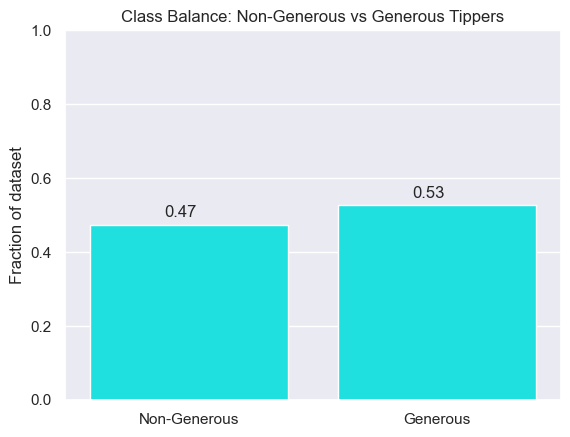

In [146]:
# Depict the class balance
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(x[i]-0.1, y[i]+0.02, s=round(y[i],2))

ax = sns.barplot(x=class_balance.index, 
                 y=class_balance.values, color='aqua')
ax.set_ylim([0,1])
ax.set_xticklabels(['Non-Generous','Generous'])
plt.xlabel('')
plt.ylabel('Fraction of dataset')
plt.title('Class Balance: Non-Generous vs Generous Tippers')
addlabels(class_balance.index, class_balance.values)
plt.show()

A little over half of the customers in this dataset were "generous" (tipped ≥ 20%). The dataset is very nearly balanced.

To determine a metric, consider the cost of both kinds of model error:
- False positives (the model predicts a tip ≥ 20%, but the customer does not give one)
- False negatives (the model predicts a tip < 20%, but the customer gives more)

False positives are worse for cab drivers, because they would pick up a customer expecting a good tip and then not receive one, frustrating the driver.

False negatives are worse for customers, because a cab driver would likely pick up a different customer who was predicted to tip more—even when the original customer would have tipped generously.

The stakes are relatively even. We want to help taxi drivers make more money, but we don't want this to anger customers. Our metric should weigh both precision and recall equally. 

Hence, we will chose the $F_1$ score which is the harmonic mean between precision and recall.

<a id='construct'></a>
# **Construct** stage of PA**C**E workflow
***
> Data models and machine learning algorithms are built, interpreted, and revised to uncover relationships within the data and unlock insights.

## Modeling

If we want to save the model(s) to file so we don't need to retrain:

In [90]:
# Define a path to the folder where you want to save the model
path = 'data/'

def write_pickle(path, model_object, save_name:str):
    '''
    save_name is a string.
    '''
    with open(path + save_name + '.pickle', 'wb') as to_write:
        pickle.dump(model_object, to_write)

def read_pickle(path, saved_model_name:str):
    '''
    saved_model_name is a string.
    '''
    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)

        return model

### Split the data

In [91]:
# Isolate target variable (y)
y = df2['generous']

# Isolate features (X)
X = df2.drop(columns = 'generous')

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

### Random forest <a id='forest'></a>

Tune a random forest model.

In [92]:
# Instantiate random forest classifier
rf = RandomForestClassifier(random_state=42)

# Define a set of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1']

# Create dictionary of hyperparameters to tune 
cv_params = {'max_depth': [8,10,None], 
             'max_features': [5,6,7],
             'max_samples': [0.6,0.7,0.8], 
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2],
             'n_estimators': [50, 75, 100]
             } 

# Instantiate GridSearchCV object
rf1 = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='f1', n_jobs=-1, verbose=2)

In [93]:
%%time
# Fit to training data
if load_models is False:
    rf1.fit(X_train, y_train) # if commented out, then model will be loaded instead

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 10 µs


In [94]:
if load_models:
    # Load model
    rf1 = read_pickle(path, 'RF_cv_model')
    print('Model loaded')
else:
    # Save model
    write_pickle(path, rf1, 'RF_cv_model')
    print('Model pickled!')

Model loaded


In [95]:
# Examine best score
rf1.best_score_

0.749835313356997

In [96]:
# Examine the best combination of hyperparameters
rf1.best_params_

{'max_depth': 10,
 'max_features': 6,
 'max_samples': 0.8,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 50}

<br>**Random forest CV results**

First create a function to output all model scores as a table:

In [97]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
    model_name (string): what you want the model to be called in the output table
    model_object: a fit GridSearchCV object
    metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy',
                  }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract Accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                         },
                        )
    return table

In [98]:
# Create this table that will hold all future results as well
results_table = make_results('RF CV', rf1, 'f1')
results_table

,model,precision,recall,F1,accuracy
0,RF CV,0.687342,0.824984,0.749835,0.710284


<br>**Random forest test results**

Note: For this project, we will use several models to predict on the test data. This decision comes with a trade-off:
- The benefit is that we get to train and test on a larger portion of this relatively small dataset, rather than removing an extra portion for validation.
- The drawback of using test data for model selection, is that we are compromising objectivity because we are using the "unseen" data to make a decision. In other words, we are effectively using the test data as an extra step in "tuning" the predictive algorithm.

In [99]:
# Get scores on test data
rf_preds = rf1.best_estimator_.predict(X_test)

In [100]:
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

    In:
    model_name (string): Your choice: how the model will be named in the output table
    preds: numpy array of test predictions
    y_test_data: numpy array of y_test data

    Out:
    table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy = metrics.accuracy_score(y_test_data, preds)
    precision = metrics.precision_score(y_test_data, preds)
    recall = metrics.recall_score(y_test_data, preds)
    f1 = metrics.f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                        'precision': [precision],
                        'recall': [recall],
                        'F1': [f1],
                        'accuracy': [accuracy]
                        })

    return table

In [101]:
# Get scores on test data
rf_test_results = get_test_scores('RF test', rf_preds, y_test)

# Append them to master table
results_table = pd.concat([results_table, rf_test_results], axis=0)
results_table

,model,precision,recall,F1,accuracy
0,RF CV,0.687342,0.824984,0.749835,0.710284
0,RF test,0.677880,0.827629,0.745307,0.702260


### XGBoost <a id='boost'></a>

We will try to improve the scores using a tuned XGBoost model

In [102]:
# Instantiate XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=42) 

# 2. Create dictionary of hyperparameters to tune
cv_params = {'learning_rate': [0.1, 0.3],
             'max_depth': [2,4,6], 
             'min_child_weight': [1,3],
             'n_estimators': [75, 100, 250, 500]
             }  

# Define a set of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1']

# Instantiate the GridSearchCV object
xgb1 = GridSearchCV(xgb, cv_params, scoring=scoring, cv=4, refit='f1', n_jobs=-1, verbose=1)

In [103]:
%%time
# Fit to training data
if load_models is False:
    xgb1.fit(X_train, y_train) # if commented out, then model will be loaded instead

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 2.86 µs


In [104]:
if load_models:
    # Load model
    xgb1 = read_pickle(path, 'XGB_cv_model')
    print('Model loaded')
else:
    # Save model
    write_pickle(path, xgb1, 'XGB_cv_model')
    print('Model pickled!')

Model loaded


In [105]:
# Examine best score
xgb1.best_score_

0.7478344860759515

In [106]:
# Examine best combination of parameters
xgb1.best_params_

{'learning_rate': 0.1,
 'max_depth': 2,
 'min_child_weight': 3,
 'n_estimators': 75}

<br>**XGB CV results**

In [107]:
xgb_cv_results = make_results('XGB CV', xgb1, 'f1')
results_table = pd.concat([results_table, xgb_cv_results], axis=0)

<br>**XGB test results**

In [108]:
# Get scores on test data
xgb_preds = xgb1.best_estimator_.predict(X_test)
xgb_test_results = get_test_scores('XGB test ', xgb_preds, y_test)
results_table = pd.concat([results_table, xgb_test_results], axis=0)

<br>**All results**

In [109]:
results_table

,model,precision,recall,F1,accuracy
0,RF CV,0.687342,0.824984,0.749835,0.710284
0,RF test,0.677880,0.827629,0.745307,0.702260
0,XGB CV,0.694147,0.810672,0.747834,0.712250
0,XGB test,0.686614,0.813939,0.744875,0.706518


Comparing the $F_1$ scores on the test data, the random forest model is every so slightly better. Either model would be fine though, but since the random forest model requires less computing time, let's choose it for production. 

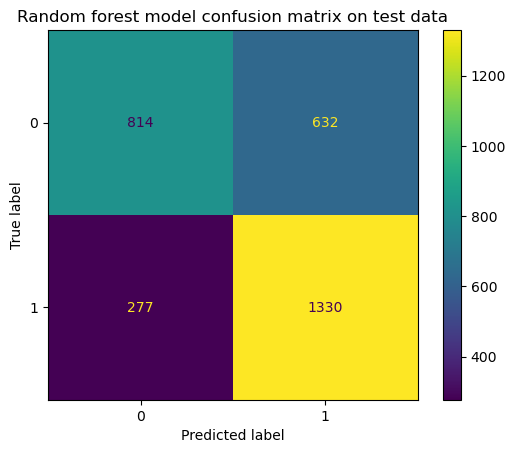

In [110]:
sns.reset_defaults() # remove custom styling that interferes

# Generate array of values for confusion matrix
cm = metrics.confusion_matrix(y_test, rf_preds)

# Plot confusion matrix
disp = metrics.ConfusionMatrixDisplay(cm, display_labels=rf1.classes_)
disp.plot(values_format='')
plt.title('Random forest model confusion matrix on test data')
plt.show()

Considering that the classes are well balanced (53% vs 47%, 1 vs 0), it is noteworthy that the model is more than twice as likely to predict a false positive (FP) than a false negative (FN). (It explains why precision is much worse than recall.) This is unfortunate, because it means a driver will more often be disappointed by a tip they were expecting to be generous rather than surprised by a generous tip they were not expecting.

<br>**Feature importance**

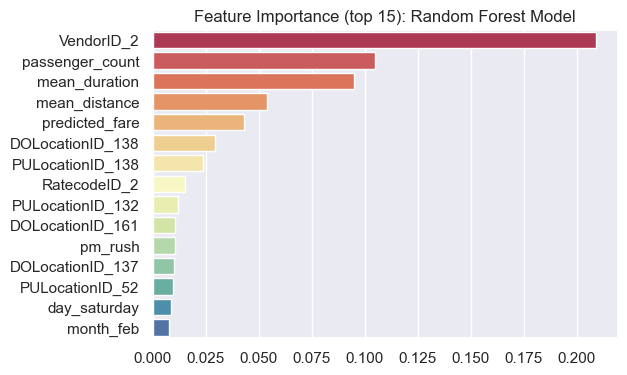

In [111]:
sns.set(style='darkgrid')

# Random forest model
plt.figure(figsize=(6,4))

rf_importances = pd.Series(rf1.best_estimator_.feature_importances_, 
                           index=X_test.columns)

rf_importances = rf_importances.sort_values(ascending=False)[:15]

sns.barplot(x=rf_importances.values, y=rf_importances.index, palette='Spectral')

plt.title('Feature Importance (top 15): Random Forest Model')
plt.show()

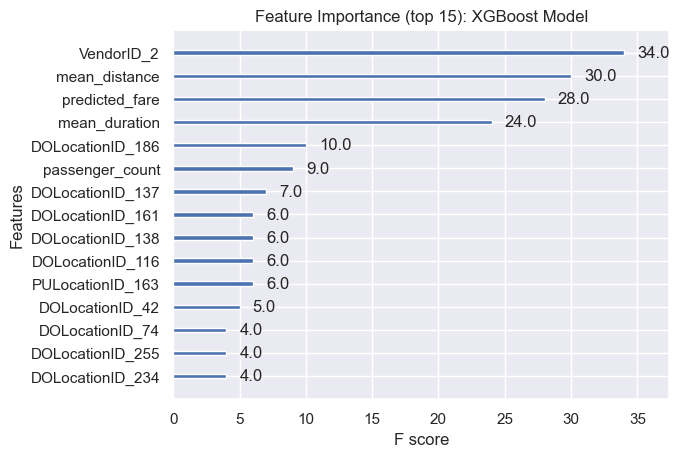

In [112]:
# Gradient boosting machine model
plot_importance(xgb1.best_estimator_, max_num_features=15)
plt.title('Feature Importance (top 15): XGBoost Model')
plt.show()

<a id='execute'></a>
# **Execute** stage of PAC**E** workflow
***
> Present findings with internal and external stakeholders, answer questions, consider different viewpoints, and make recommendations.

An A/B test was conducted, confirming that there is a statistically significant difference in average `fare amount` between customers who use credit cards and customers who use cash--that is, customers spend more when paying by credit card. However, the direction of causation is unclear, as it may just as well be the case that customers faced with a larger bill are more likely to pay with credit card.

A multiple linear regression model was created to predict the `fare amount`. It performed well with an $R^2 = 0.86$ on the test set. The predictor variables that contributed most to the model were `mean_distance` and `mean_duration` (two engineered variables based on the statistics of trips between each pair of pickup and dropoff locations). These features are highly correlated so it is best not to draw any conclusions about their implications, as the point of this regression model, aftereall, is to use the `predicted fare` for downstream modeling efforts.  

The `predicted fare` from this regression model was used as an independent variable in the final model to predict whether the customer would leave a generous tip (ie, $\ge 20\%$). Two machine learning algorithms were compared: Random Forest and  XGBoost. The target statistic used to select the superior model was $F_1$ score. The Random Forest model ever so slightly outperformed XGBoost, having an $F_1$ score of 0.745 on the test set.

The most important features are `VendorID`, `passenger_count`, `mean_duration`, `mean_distance`, and `predicted_fare`. During EDA, we saw that Vendor 2 had a slightly higher total amount on average, which could mean that they recieve better tips on average; this may be worth investigating with a hypothesis test. We also saw during EDA that tips are on average greatest when there are 2 passengers and least when there are 4 passengers, but this could be due to sample size differences. Mean duration and distance were also the top predictors in the upstream linear regression model.

In conclusion, the chosen algorithm (Random Forest) is good enough at predicting generous tippers, with reasonably strong precision (0.678), recall (0.828), F1 (0.745), and accuracy (0.702) scores. This model is roughly twice as likely to predict a false positive (FP) than a false negative (FN), which means that, when the model is wrong, the driver will more often be disappointed by the lack of a generous tip than be pleasantly surprised by a generous tip.

Significant improvement to the model is unlikely without additional data, such as past tipping behavior for customers. There is opportunity to derive further insight from the data by, for example, clustering with K-Means and analyzing the resulting clusters.
